In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE

import statsmodels.api as stm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import os
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None
#pip install plot-metric
from plot_metric.functions import BinaryClassification

Using TensorFlow backend.


### Functions

In [2]:
#%age of null
def percent_null(data):
    percent_null = ((data.isnull().sum()/len(data))*100).sort_values(ascending=False)
    return percent_null

In [3]:
#derived feature
def total_amt_data(data):
    for i in range(6,10):
        data['total_data_rech_amt_'+str(i)] = data['total_rech_data_'+str(i)]*data['av_rech_amt_data_'+str(i)]

In [4]:
#derived feature 
def total_vol_data(data):
    for i in range(6,10):
        data['total_vol_data_mb_'+str(i)] = (data['vol_2g_mb_'+str(i)]+data['vol_3g_mb_'+str(i)]).astype(int)

In [5]:
def fill_missing_values(data,input_list):
    for val in input_list:
        data[val].fillna(0, inplace=True) 

In [6]:
def draw_box_plot(plotdata, log_scale = True):
    plt.figure(figsize=(8, 6))
    sns.set_style("darkgrid")
    g = sns.boxplot(data = plotdata)
    if(log_scale):
        g.set_yscale("log")
    plt.tight_layout()

In [7]:
def get_columns_with_substring(data, substring1, substring2= '', conditionColumn = '', conditionValue=''):
    #sel_columns_data = data[data.columns[data.columns.to_series().str.contains(substring1) & data.columns.to_series().str.contains(substring2)]]
    if(conditionColumn != ''):
        return data[data[conditionColumn] == conditionValue][data.columns[data.columns.to_series().str.contains(substring1) & data.columns.to_series().str.contains(substring2)]]
    else:
        return data[data.columns[data.columns.to_series().str.contains(substring1) & data.columns.to_series().str.contains(substring2)]]

In [8]:
def print_outlier_counts_in_df(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print("Full Data Total:")
    print(df.sum())
    print("Outlier Total:")
    print(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum())

In [9]:
def count_plot(col):
    ax = high_value_cust_data[col].value_counts().plot.bar(title='Distribution of '+ col)
    ax.set(xlabel=col, ylabel='count')
    return ax

In [10]:
def display_values(ax):
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())

    total = sum(totals)
    
    for i in ax.patches:
        ax.text(i.get_x()+.12, i.get_height(),str(round((i.get_height()/total)*100, 2))+'%',fontsize=12,color='black')
    return

### Data loading

In [13]:
churn_data = pd.read_csv("telecom_churn_data.csv")

### Data understanding

In [12]:
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [13]:
churn_data.shape

(99999, 226)

In [14]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [15]:
churn_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [16]:
churn_data.nunique()

mobile_number               99999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
last_date_of_month_9            1
arpu_6                      85681
arpu_7                      85308
arpu_8                      83615
arpu_9                      79937
onnet_mou_6                 24313
onnet_mou_7                 24336
onnet_mou_8                 24089
onnet_mou_9                 23565
offnet_mou_6                31140
offnet_mou_7                31023
offnet_mou_8                30908
offnet_mou_9                30077
roam_ic_mou_6                6512
roam_ic_mou_7                5230
roam_ic_mou_8                5315
roam_ic_mou_9                4827
roam_og_mou_6                8038
roam_og_mou_7                6639
roam_og_mou_8                6504
roam_og_mou_9                5882
loc_og_t2t_mou

Unique values are present which may not be useful will handle after filter

In [17]:
print(churn_data.isnull().sum())

mobile_number                   0
circle_id                       0
loc_og_t2o_mou               1018
std_og_t2o_mou               1018
loc_ic_t2o_mou               1018
last_date_of_month_6            0
last_date_of_month_7          601
last_date_of_month_8         1100
last_date_of_month_9         1659
arpu_6                          0
arpu_7                          0
arpu_8                          0
arpu_9                          0
onnet_mou_6                  3937
onnet_mou_7                  3859
onnet_mou_8                  5378
onnet_mou_9                  7745
offnet_mou_6                 3937
offnet_mou_7                 3859
offnet_mou_8                 5378
offnet_mou_9                 7745
roam_ic_mou_6                3937
roam_ic_mou_7                3859
roam_ic_mou_8                5378
roam_ic_mou_9                7745
roam_og_mou_6                3937
roam_og_mou_7                3859
roam_og_mou_8                5378
roam_og_mou_9                7745
loc_og_t2t_mou

In [18]:
#Understanding data which has less unique values
churn_data.loc[:, churn_data.nunique() < 6].head(50)

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0,0,1.0,1.0,1.0,NaN
1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,0,NaN,1.0,1.0,NaN
2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,1.0
3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,0,0.0,NaN,NaN,NaN
5,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
6,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN
8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,0,NaN,1.0,1.0,NaN
9,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0,0,NaN,1.0,NaN,NaN


In [19]:
percent_null(churn_data)


count_rech_2g_6             74.846748
date_of_last_rech_data_6    74.846748
count_rech_3g_6             74.846748
av_rech_amt_data_6          74.846748
max_rech_data_6             74.846748
total_rech_data_6           74.846748
arpu_3g_6                   74.846748
arpu_2g_6                   74.846748
night_pck_user_6            74.846748
fb_user_6                   74.846748
arpu_3g_7                   74.428744
count_rech_2g_7             74.428744
fb_user_7                   74.428744
count_rech_3g_7             74.428744
arpu_2g_7                   74.428744
av_rech_amt_data_7          74.428744
max_rech_data_7             74.428744
night_pck_user_7            74.428744
total_rech_data_7           74.428744
date_of_last_rech_data_7    74.428744
night_pck_user_9            74.077741
date_of_last_rech_data_9    74.077741
fb_user_9                   74.077741
arpu_2g_9                   74.077741
max_rech_data_9             74.077741
arpu_3g_9                   74.077741
total_rech_d

### Data preparation

Some column names are not right fill fix them first 

In [14]:
churn_data.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                               'jul_vbc_3g':'vbc_3g_7',
                               'aug_vbc_3g':'vbc_3g_8',
                               'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

We need to predict churn only for the high-value customers. Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

**Average recharge amount = Mean(total_rech_amt_6,total_rech_amt_7,total_rech_data_6,total_rech_data_7)**
As we can see above total_rech_amt_6 and total_rech_amt_7 has no null values but total_rech_data_6 and total_rech_data_7 has more than 70% missing values so will handle these **missing values** first 

In [15]:
missing_value_rech_list = ['total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_data_8',
                          'av_rech_amt_data_8']
fill_missing_values(churn_data,missing_value_rech_list)

In [22]:
percent_null(churn_data)

night_pck_user_6            74.846748
fb_user_6                   74.846748
count_rech_3g_6             74.846748
max_rech_data_6             74.846748
date_of_last_rech_data_6    74.846748
arpu_3g_6                   74.846748
arpu_2g_6                   74.846748
count_rech_2g_6             74.846748
fb_user_7                   74.428744
date_of_last_rech_data_7    74.428744
count_rech_2g_7             74.428744
count_rech_3g_7             74.428744
night_pck_user_7            74.428744
arpu_3g_7                   74.428744
max_rech_data_7             74.428744
arpu_2g_7                   74.428744
arpu_2g_9                   74.077741
max_rech_data_9             74.077741
night_pck_user_9            74.077741
fb_user_9                   74.077741
total_rech_data_9           74.077741
date_of_last_rech_data_9    74.077741
av_rech_amt_data_9          74.077741
count_rech_3g_9             74.077741
count_rech_2g_9             74.077741
arpu_3g_9                   74.077741
date_of_last

### Deriving new columns
Since total amount for data is not given we can derive it from average amount*total number recharge done


In [16]:
#total_data_rech_amt_  per month
total_amt_data(churn_data)

#total volume per month
total_vol_data(churn_data)

In [24]:
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,

##### Observe Data Relativity

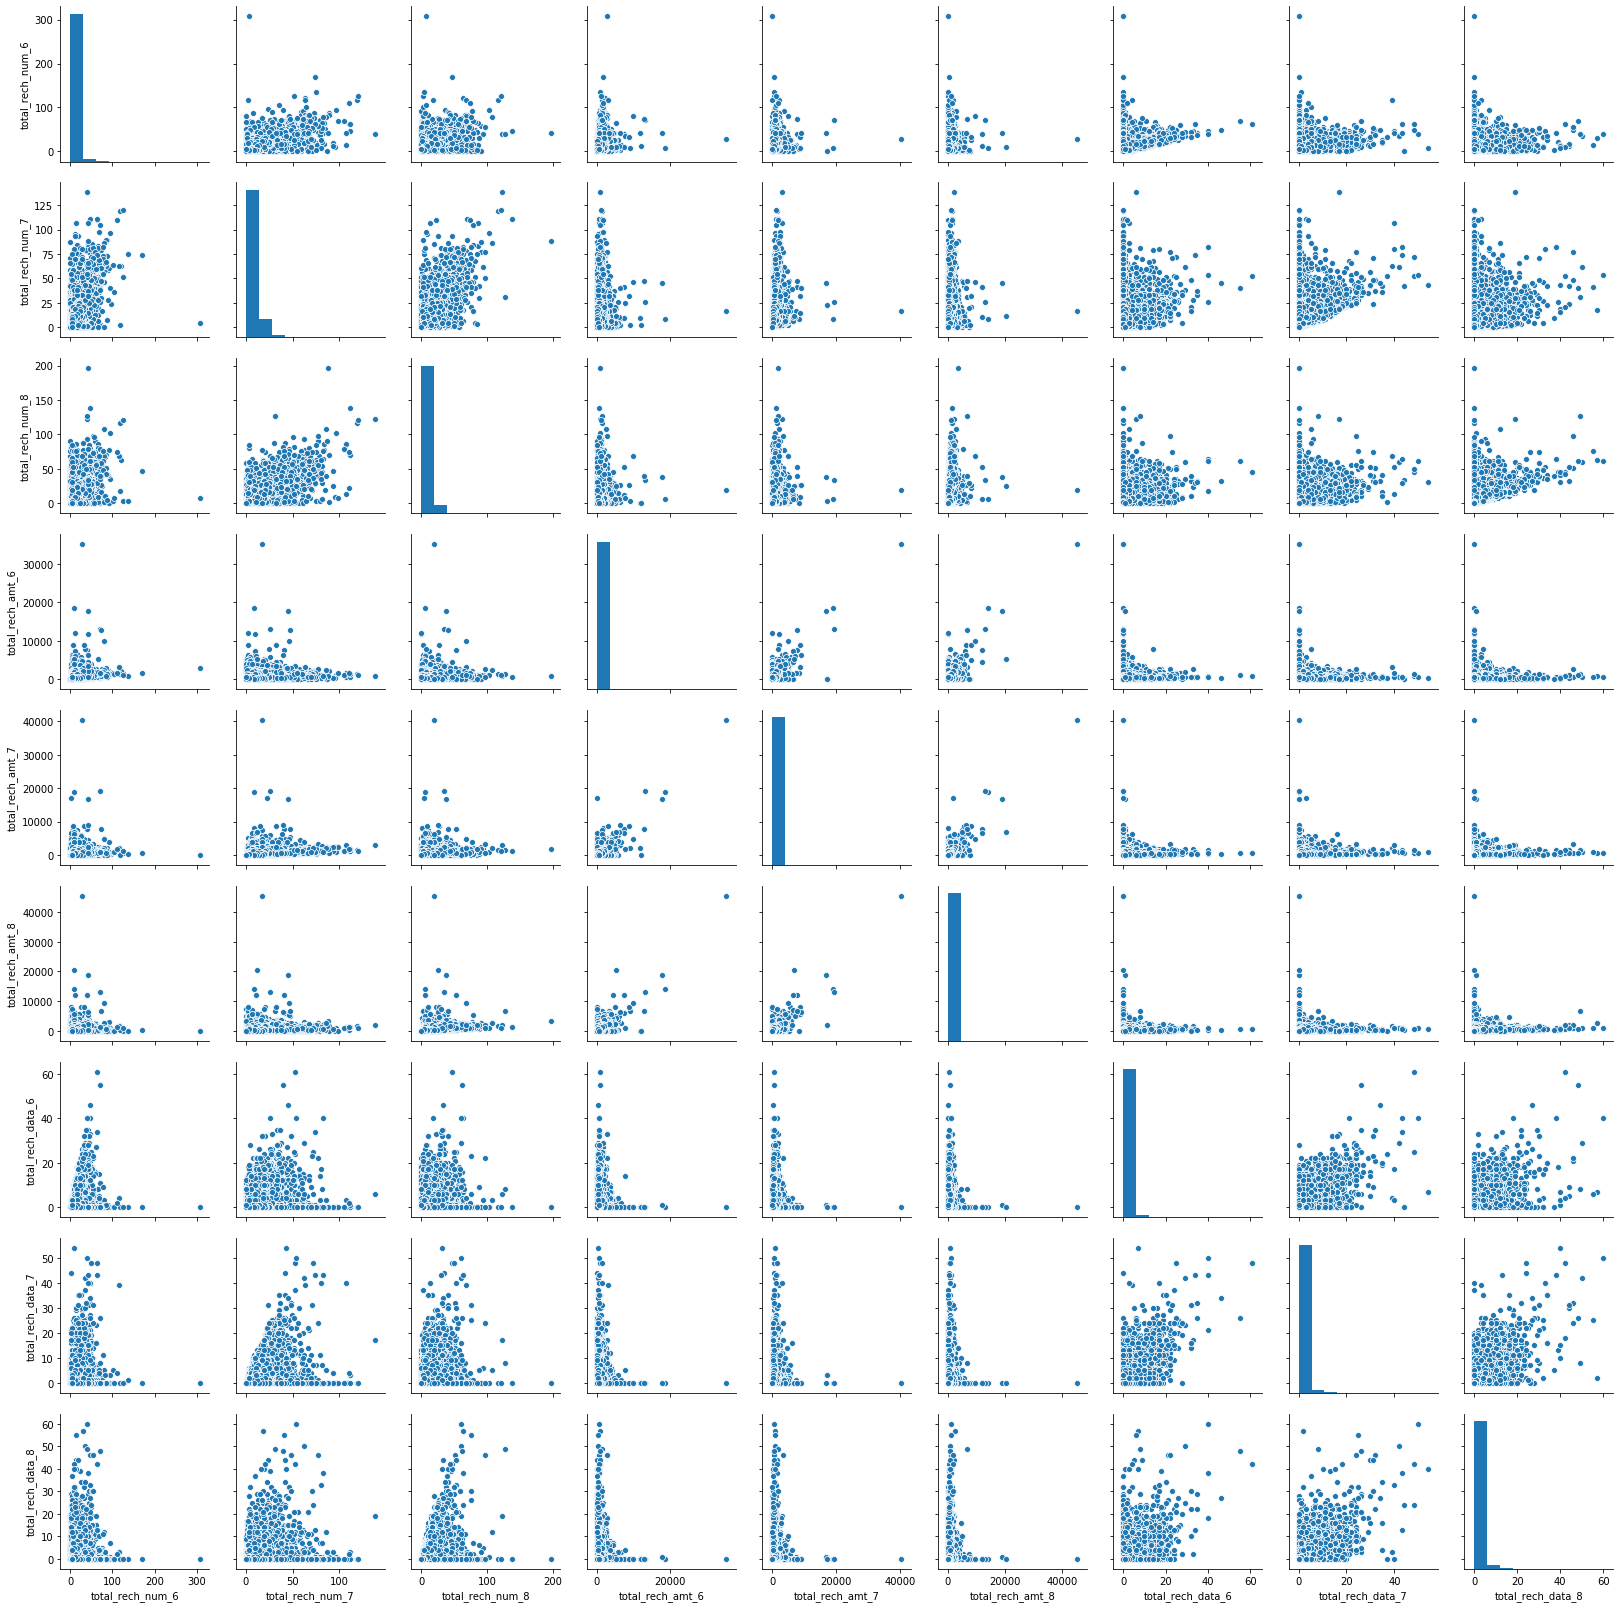

In [25]:
sns.pairplot(get_columns_with_substring(churn_data, 'total_rech_|avg_rech_amt', '_6|_7|_8'))

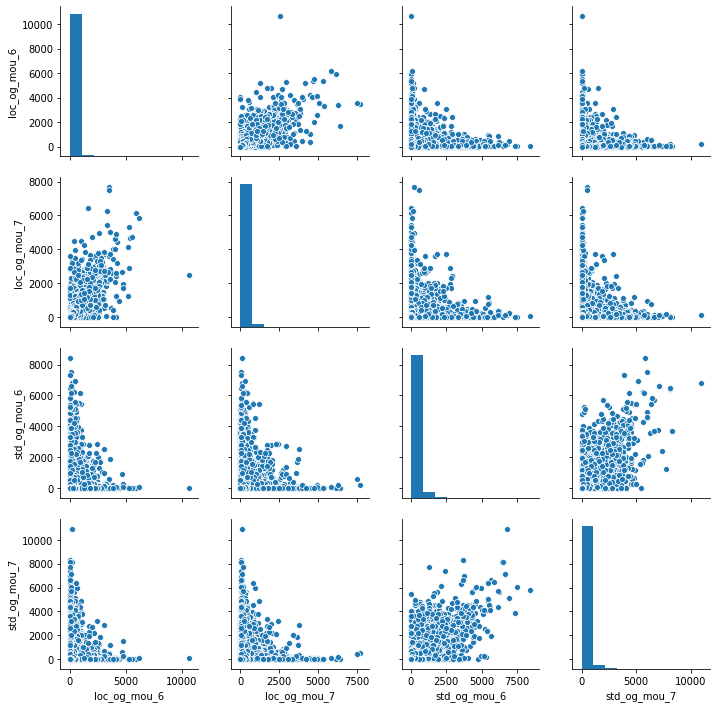

In [26]:
sns.pairplot(get_columns_with_substring(churn_data, 'std_og_mou|loc_og_mou', '_6|_7'))

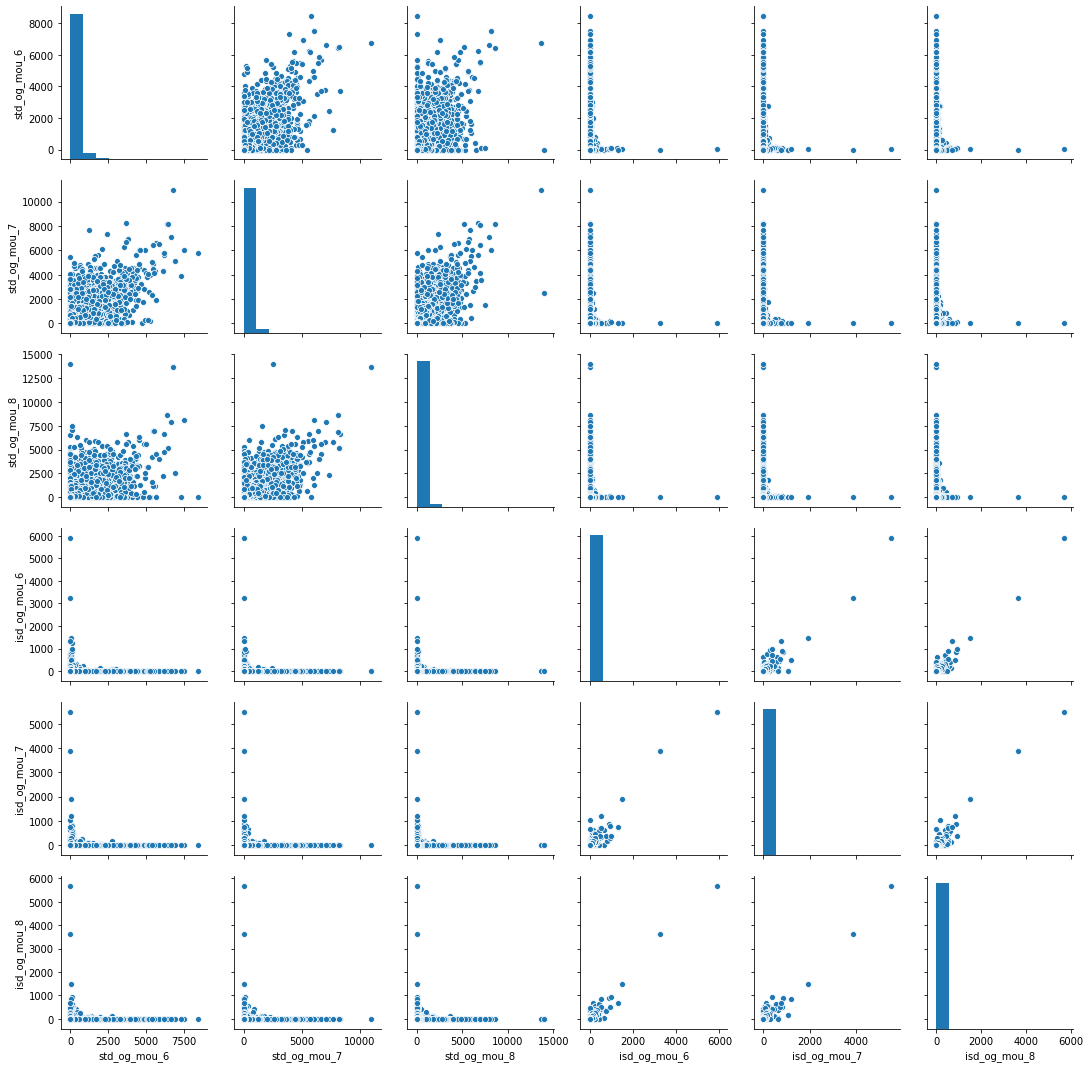

In [27]:
sns.pairplot(get_columns_with_substring(churn_data, 'isd_og_mou|std_og_mou', '_6|_7|_8'))

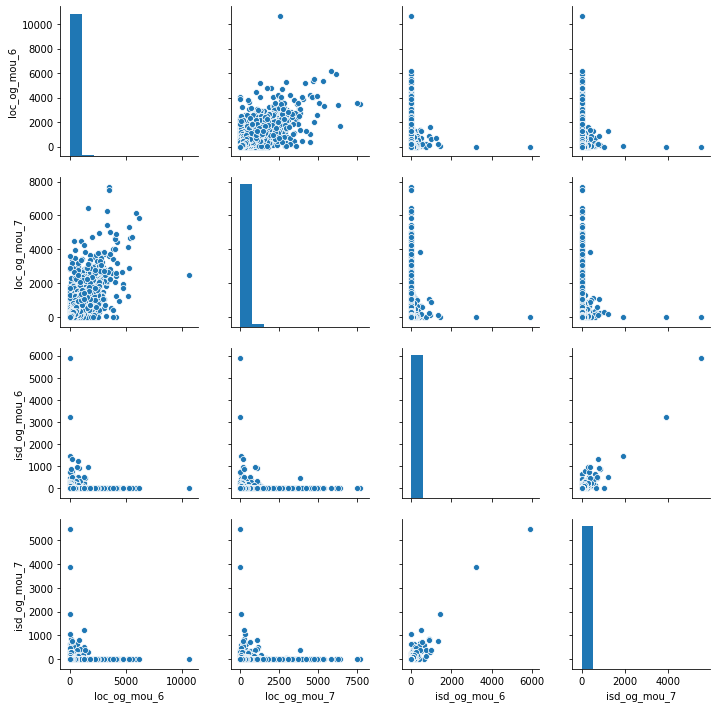

In [28]:
sns.pairplot(get_columns_with_substring(churn_data, 'isd_og_mou|loc_og_mou', '_6|_7'))

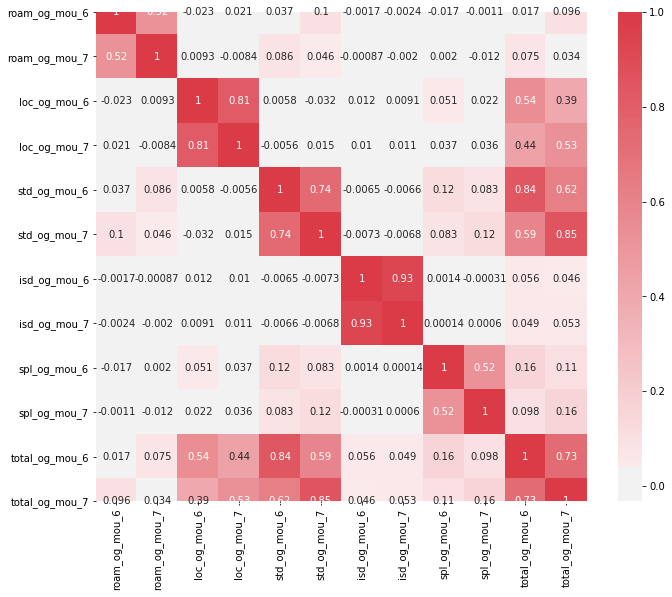

In [29]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap((get_columns_with_substring(churn_data, '_og_mou', '_6|_7')).corr(), cmap=cmap, center=0, annot=True)

### Filter out high value customer 

In [30]:
churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,

In [17]:
avg_rech_amnt_month_6_7 = churn_data[['total_data_rech_amt_6','total_data_rech_amt_7','total_rech_amt_6','total_rech_amt_7']].mean(axis = 1)
high_value_70_percentile = np.percentile(avg_rech_amnt_month_6_7, 70)
print(high_value_70_percentile)

239.0


In [18]:
high_value_cust_data = churn_data[avg_rech_amnt_month_6_7 > high_value_70_percentile]
high_value_cust_data.shape

(29953, 234)

In [33]:
high_value_cust_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44

In [19]:
#reset index
high_value_cust_data = high_value_cust_data.reset_index(drop=True)
high_value_cust_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44

### Tag churners and remove attributes of the churn phase
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes to use:
total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

In [20]:
(high_value_cust_data[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']]).head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00
2,34.91,142.18,0.00,0.00
3,252.61,1031.53,0.00,0.00
4,127.48,127.63,13.93,314.74
5,114.16,1.70,30.92,5588.11
6,114.09,708.04,0.00,0.00
7,165.84,89.13,0.00,0.00
8,894.81,2319.01,0.00,0.00
9,680.61,503.06,0.82,0.00


In [36]:
high_value_cust_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44

In [21]:
high_value_cust_data['churn'] = np.where( (high_value_cust_data['total_ic_mou_9'] == 0) & (high_value_cust_data['total_og_mou_9'] == 0)  &  (high_value_cust_data['vol_2g_mb_9'] == 0) & (high_value_cust_data['vol_3g_mb_9'] == 0) , 1, 0)
high_value_cust_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_data_rech_amt_9,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,total_vol_data_mb_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,Na

remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [22]:
colNames_9 = high_value_cust_data.columns[high_value_cust_data.columns.str.contains(pat = '_9')] 

print(colNames_9)
print(len(colNames_9))

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user

In [23]:
high_value_cust_data.drop(colNames_9, axis=1, inplace = True)


In [24]:
high_value_cust_data.shape

(29953, 178)

In [41]:
high_value_cust_data.nunique()

mobile_number               29953
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
arpu_6                      29029
arpu_7                      29040
arpu_8                      28035
onnet_mou_6                 16872
onnet_mou_7                 16973
onnet_mou_8                 15854
offnet_mou_6                21198
offnet_mou_7                21233
offnet_mou_8                20140
roam_ic_mou_6                4045
roam_ic_mou_7                3381
roam_ic_mou_8                3431
roam_og_mou_6                4742
roam_og_mou_7                3988
roam_og_mou_8                3996
loc_og_t2t_mou_6            10416
loc_og_t2t_mou_7            10388
loc_og_t2t_mou_8            10056
loc_og_t2m_mou_6            15607
loc_og_t2m_mou_7            15659
loc_og_t2m_mou_8            15118
loc_og_t2f_mou

### Data Cleaning 

In [42]:
#As noticed above there are unique cols we can drop them off first

In [25]:
unique_value_col = high_value_cust_data.nunique() == 1
unique_value_col = unique_value_col[unique_value_col == 1].index
print(unique_value_col)

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')


In [26]:
high_value_cust_data.drop(unique_value_col, axis=1, inplace = True)

In [45]:
high_value_cust_data.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,churn
0,7000842753,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,252.0,252.0,252.0,113,152,115,1
1,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0

In [46]:
high_value_cust_data.describe()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,total_vol_data_mb_6,total_vol_data_mb_7,total_vol_data_mb_8,churn
count,2.995300e+04,29953.000000,29953.000000,29953.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.00000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29953.000000,29953.000000,29953.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.00000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.00000,28781.000000,29953.000000,29953.000000,29953.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,16740.000000,17038.000000,15935.000000,16740.000000,17038.000000,15935.000000,16740.000000,17038.000000,15935.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,16740.000000,17038.000000,15935.000000,16740.000000,17038.000000,159

In [27]:
high_value_cust_data.shape

(29953, 165)

In [28]:
#also we will drop mobile number as its just id and wont help in analysis
high_value_cust_data.drop(['mobile_number'], axis=1, inplace = True)

In [49]:
# fixing missing values 

In [50]:
percent_null(high_value_cust_data)

count_rech_2g_8             46.799987
fb_user_8                   46.799987
arpu_3g_8                   46.799987
max_rech_data_8             46.799987
count_rech_3g_8             46.799987
arpu_2g_8                   46.799987
date_of_last_rech_data_8    46.799987
night_pck_user_8            46.799987
count_rech_2g_6             44.112443
fb_user_6                   44.112443
arpu_3g_6                   44.112443
max_rech_data_6             44.112443
count_rech_3g_6             44.112443
night_pck_user_6            44.112443
date_of_last_rech_data_6    44.112443
arpu_2g_6                   44.112443
arpu_2g_7                   43.117551
count_rech_3g_7             43.117551
night_pck_user_7            43.117551
arpu_3g_7                   43.117551
max_rech_data_7             43.117551
fb_user_7                   43.117551
date_of_last_rech_data_7    43.117551
count_rech_2g_7             43.117551
loc_og_t2f_mou_8             3.912797
isd_ic_mou_8                 3.912797
loc_og_mou_8

In [51]:
# Lets first consider coloumns with highest missing values 

In [29]:
result = percent_null(high_value_cust_data)>40
result[result > 0.40].index

Index(['count_rech_2g_8', 'fb_user_8', 'arpu_3g_8', 'max_rech_data_8',
       'count_rech_3g_8', 'arpu_2g_8', 'date_of_last_rech_data_8',
       'night_pck_user_8', 'count_rech_2g_6', 'fb_user_6', 'arpu_3g_6',
       'max_rech_data_6', 'count_rech_3g_6', 'night_pck_user_6',
       'date_of_last_rech_data_6', 'arpu_2g_6', 'arpu_2g_7', 'count_rech_3g_7',
       'night_pck_user_7', 'arpu_3g_7', 'max_rech_data_7', 'fb_user_7',
       'date_of_last_rech_data_7', 'count_rech_2g_7'],
      dtype='object')

All the values which are related to recharge/data will impute them

In [30]:
list_col_impute = ['count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6','max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
        'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

fill_missing_values(high_value_cust_data,list_col_impute)

In [31]:
#date for so many missing rows droping them off
high_value_cust_data.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace = True)

In [55]:
percent_null(high_value_cust_data)

isd_og_mou_8             3.912797
loc_ic_t2t_mou_8         3.912797
loc_og_t2c_mou_8         3.912797
loc_og_mou_8             3.912797
std_og_t2t_mou_8         3.912797
std_og_t2m_mou_8         3.912797
std_og_t2f_mou_8         3.912797
std_og_mou_8             3.912797
spl_og_mou_8             3.912797
og_others_8              3.912797
loc_ic_t2m_mou_8         3.912797
loc_og_t2m_mou_8         3.912797
loc_ic_t2f_mou_8         3.912797
loc_ic_mou_8             3.912797
ic_others_8              3.912797
isd_ic_mou_8             3.912797
spl_ic_mou_8             3.912797
std_ic_t2t_mou_8         3.912797
std_ic_mou_8             3.912797
std_ic_t2f_mou_8         3.912797
loc_og_t2f_mou_8         3.912797
std_ic_t2m_mou_8         3.912797
roam_og_mou_8            3.912797
offnet_mou_8             3.912797
loc_og_t2t_mou_8         3.912797
onnet_mou_8              3.912797
roam_ic_mou_8            3.912797
date_of_last_rech_8      1.943044
loc_og_t2f_mou_6         1.809502
ic_others_6   

In [32]:
#there are few more date cols which we can drop as they are not important for analysis 
# date_of_last_rech_6  date_of_last_rech_7 date_of_last_rech_8
high_value_cust_data.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], axis=1, inplace = True)

In [57]:
percent_null(high_value_cust_data)

std_ic_t2m_mou_8         3.912797
ic_others_8              3.912797
isd_og_mou_8             3.912797
std_og_t2m_mou_8         3.912797
spl_og_mou_8             3.912797
std_og_t2t_mou_8         3.912797
og_others_8              3.912797
loc_og_mou_8             3.912797
loc_ic_t2t_mou_8         3.912797
loc_og_t2c_mou_8         3.912797
loc_ic_t2m_mou_8         3.912797
loc_og_t2f_mou_8         3.912797
loc_ic_t2f_mou_8         3.912797
loc_og_t2m_mou_8         3.912797
std_og_mou_8             3.912797
loc_og_t2t_mou_8         3.912797
loc_ic_mou_8             3.912797
std_og_t2f_mou_8         3.912797
onnet_mou_8              3.912797
isd_ic_mou_8             3.912797
std_ic_t2f_mou_8         3.912797
roam_ic_mou_8            3.912797
spl_ic_mou_8             3.912797
offnet_mou_8             3.912797
roam_og_mou_8            3.912797
std_ic_t2t_mou_8         3.912797
std_ic_mou_8             3.912797
std_ic_t2f_mou_6         1.809502
spl_og_mou_6             1.809502
std_ic_mou_6  

In [33]:
#most coloumns are minutes of usage for which will impute 0 
null_cols_list = high_value_cust_data.columns[high_value_cust_data.isna().any()].tolist()
print(null_cols_list)

['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic

In [34]:
fill_missing_values(high_value_cust_data,null_cols_list)

In [35]:
percent_null(high_value_cust_data)

churn                    0.0
og_others_7              0.0
loc_ic_t2t_mou_8         0.0
loc_ic_t2t_mou_7         0.0
loc_ic_t2t_mou_6         0.0
total_og_mou_8           0.0
total_og_mou_7           0.0
total_og_mou_6           0.0
og_others_8              0.0
og_others_6              0.0
loc_ic_t2m_mou_7         0.0
spl_og_mou_8             0.0
spl_og_mou_7             0.0
spl_og_mou_6             0.0
isd_og_mou_8             0.0
isd_og_mou_7             0.0
isd_og_mou_6             0.0
std_og_mou_8             0.0
loc_ic_t2m_mou_6         0.0
loc_ic_t2m_mou_8         0.0
std_og_mou_6             0.0
std_ic_t2m_mou_6         0.0
std_ic_mou_7             0.0
std_ic_mou_6             0.0
std_ic_t2f_mou_8         0.0
std_ic_t2f_mou_7         0.0
std_ic_t2f_mou_6         0.0
std_ic_t2m_mou_8         0.0
std_ic_t2m_mou_7         0.0
std_ic_t2t_mou_8         0.0
loc_ic_t2f_mou_6         0.0
std_ic_t2t_mou_7         0.0
std_ic_t2t_mou_6         0.0
loc_ic_mou_8             0.0
loc_ic_mou_7  

In [36]:
high_value_cust_data.shape

(29953, 158)

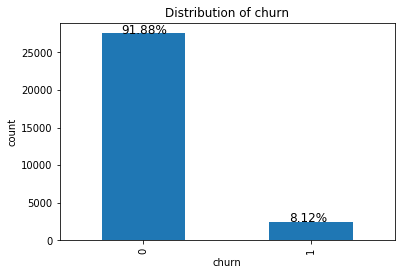

In [62]:
# %age of churn and non churn customers
ax = count_plot("churn")
display_values(ax)

We see only 8.12% of custmores have churned

### EDA 

#### Univariate Analysis
Understand customer behavior in the good phase and action phase.

In [37]:
print(get_columns_with_substring(high_value_cust_data, 'total|churn').columns)

Index(['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_data_6',
       'total_rech_data_7', 'total_rech_data_8', 'total_data_rech_amt_6',
       'total_data_rech_amt_7', 'total_data_rech_amt_8', 'total_vol_data_mb_6',
       'total_vol_data_mb_7', 'total_vol_data_mb_8', 'churn'],
      dtype='object')


Let's plot few of the columns to observe outliers influence

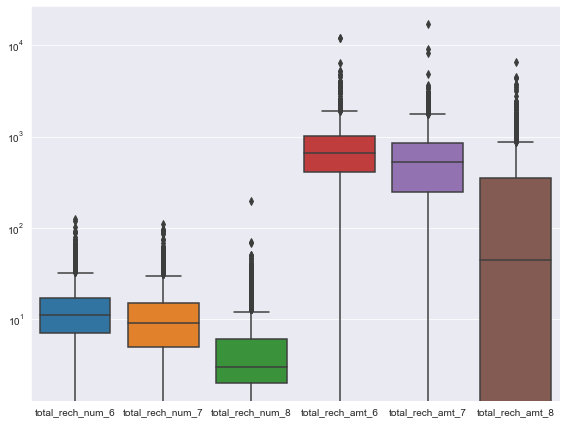

In [64]:
# Total Recharge Churn 
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'total_rech_amt|total_rech_num', '','churn', 1))

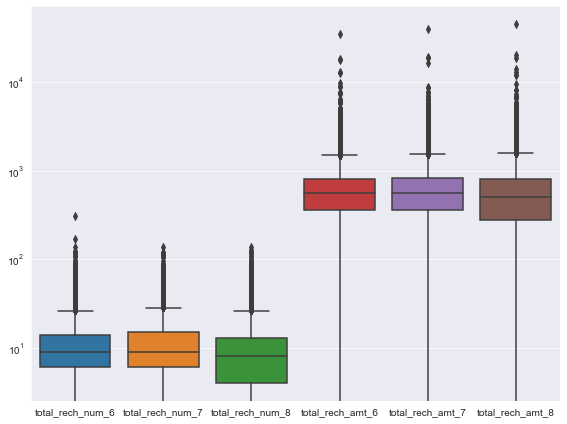

In [65]:
# Total Recharge No Churn
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'total_rech_amt|total_rech_num', '','churn', 0))

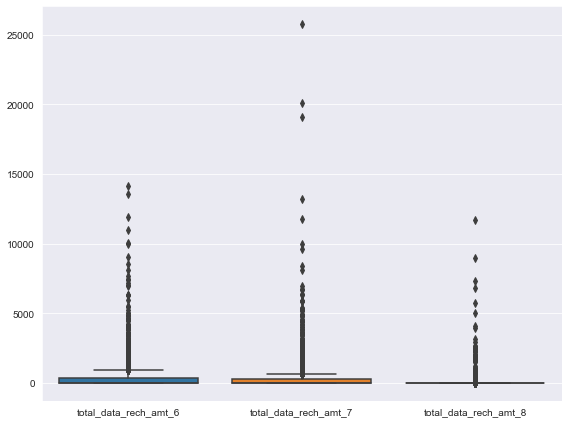

In [66]:
# Total Data Churn 
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'total_data', '','churn', 1), False)

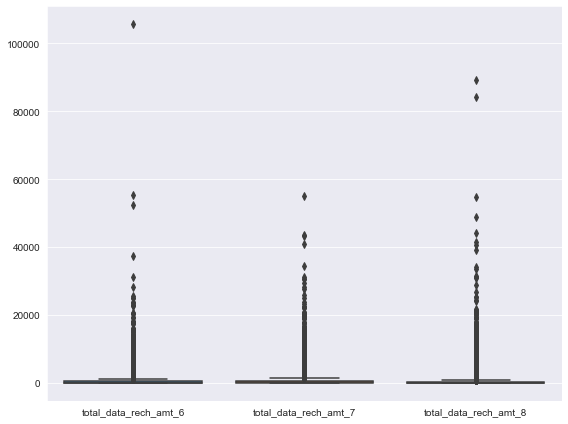

In [67]:
# Total Data NoChurn 
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'total_data', '','churn', 0), False)

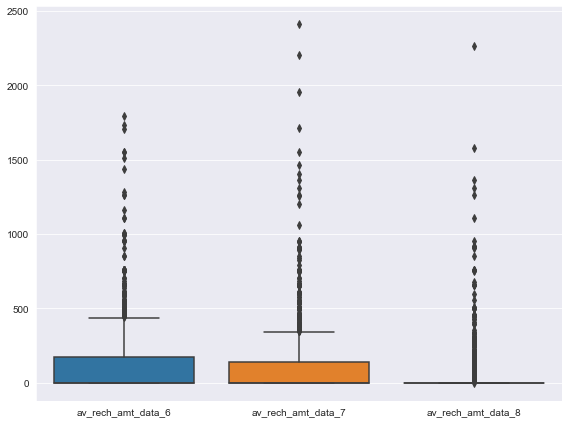

In [68]:
# Average Recharge Churn
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'av_rech_', '', 'churn', 1), False)

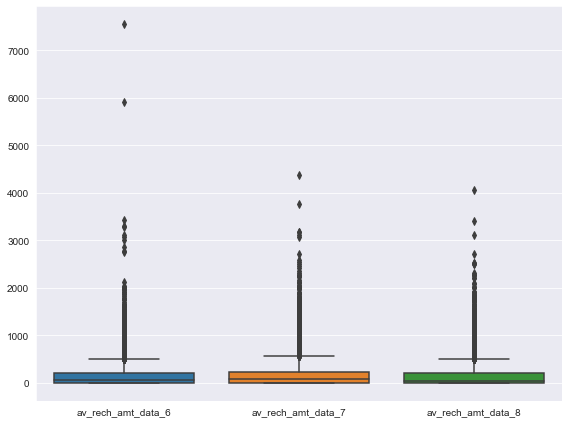

In [69]:
# Average Recharge NoChurn
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'av_rech_', '', 'churn', 0), False)

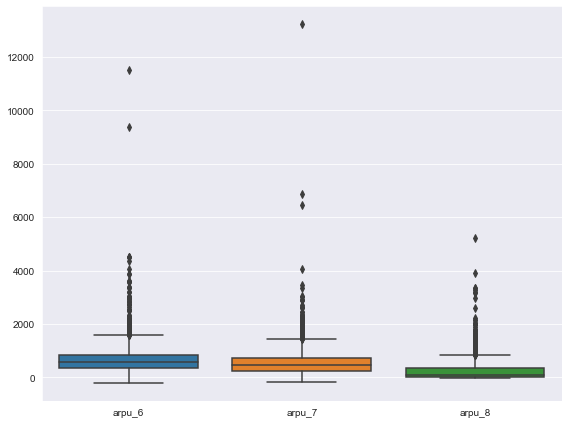

In [70]:
# ARPU for Churn customers
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'arpu_6|arpu_7|arpu_8', '', 'churn', 1), False)

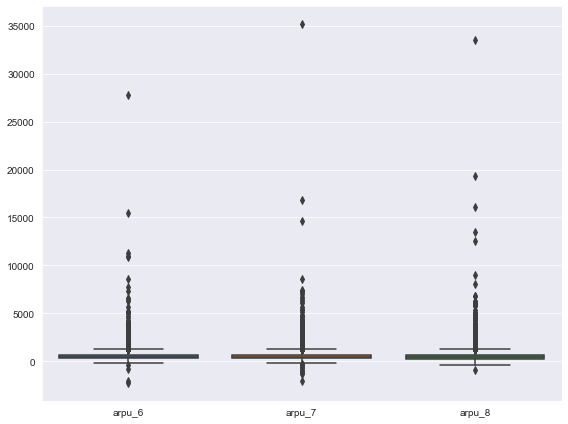

In [71]:
# ARPU for No Churn customers
draw_box_plot(get_columns_with_substring(high_value_cust_data, 'arpu_6|arpu_7|arpu_8', '', 'churn', 0), False)

In all the above plots we can observe outliers. There are quite a few outliers in all the columns. 
We can also observe that a small percentage of the outliers are too far out indicating that outlier treatment can be performed on a small percent of the data.

In [72]:
# Get correlation data for the remaining columns
c = high_value_cust_data.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

# Print top ten column group with least correlation score
print(so[1:10])

og_others_7       loc_ic_t2m_mou_8    7.949919e-07
count_rech_3g_8   std_ic_t2f_mou_8    1.511175e-06
std_ic_t2f_mou_8  count_rech_3g_8     1.511175e-06
isd_og_mou_8      vbc_3g_7            1.729277e-06
vbc_3g_7          isd_og_mou_8        1.729277e-06
og_others_8       std_ic_t2t_mou_8    3.417732e-06
std_ic_t2t_mou_8  og_others_8         3.417732e-06
loc_og_t2t_mou_7  isd_og_mou_7        1.369194e-05
isd_og_mou_7      loc_og_t2t_mou_7    1.369194e-05
dtype: float64


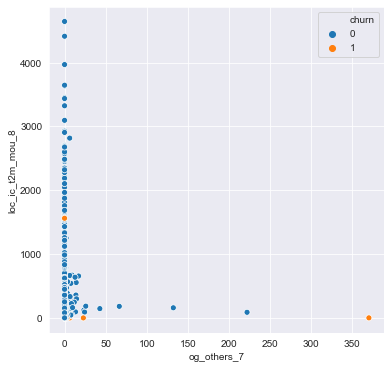

In [73]:
# Plot top 2 combinations to observe the distribution
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.scatterplot(x="og_others_7", y="loc_ic_t2m_mou_8", hue="churn", data=high_value_cust_data)

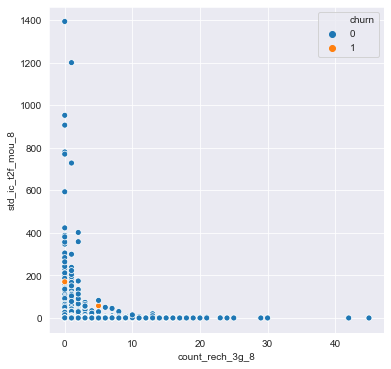

In [74]:
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.scatterplot(x="count_rech_3g_8", y="std_ic_t2f_mou_8", hue="churn", data=high_value_cust_data)

Low correlation variables does exhibit independency.

In [75]:
# Print top ten column group with highest correlation score
print(so[-166:-156])

arpu_8               total_rech_amt_8       0.955322
total_rech_amt_8     arpu_8                 0.955322
sachet_2g_6          count_rech_2g_6        0.984939
count_rech_2g_6      sachet_2g_6            0.984939
sachet_2g_7          count_rech_2g_7        0.986423
count_rech_2g_7      sachet_2g_7            0.986423
count_rech_2g_8      sachet_2g_8            0.987175
sachet_2g_8          count_rech_2g_8        0.987175
arpu_6               arpu_6                 1.000000
total_vol_data_mb_7  total_vol_data_mb_7    1.000000
dtype: float64


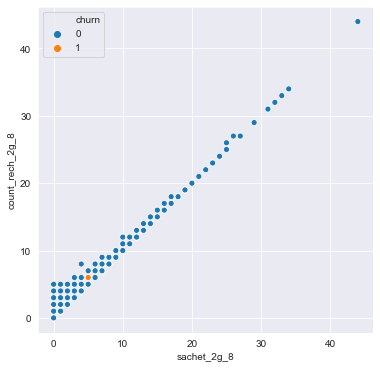

In [76]:
# Plot top 2 combinations to observe the distribution
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.scatterplot(x="sachet_2g_8", y="count_rech_2g_8", hue="churn", data=high_value_cust_data)

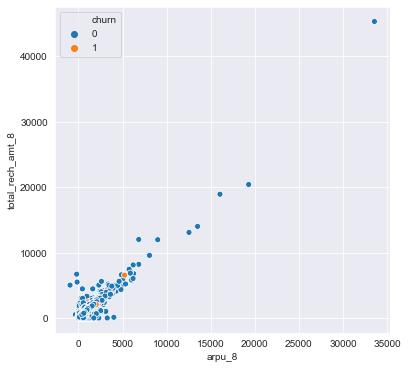

In [77]:
f, ax = plt.subplots(figsize=(6, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.scatterplot(x="arpu_8", y="total_rech_amt_8", hue="churn", data=high_value_cust_data)

Variables with high correlation is having linear distribution.

In [78]:
# understand if facebook users have any trend

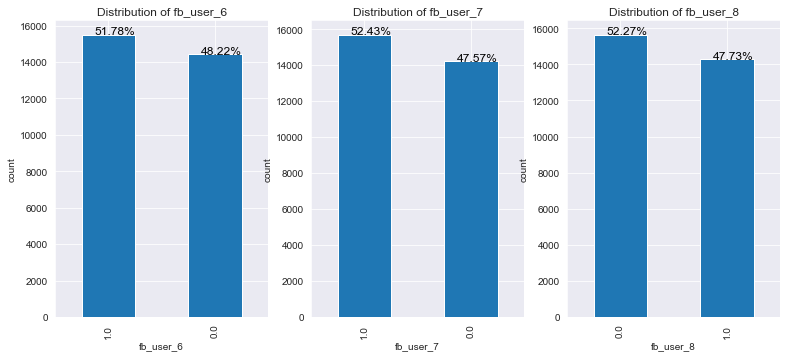

In [79]:
facebook_list = [ 'fb_user_6', 'fb_user_7', 'fb_user_8']
plt.figure(figsize = (13, 12))
counter = 1
for col_list in facebook_list:
    plt.subplot(2, 3, counter)
    ax = count_plot(col_list)
    display_values(ax)
    counter += 1
plt.show()

%age of Facebook users has declined in 8th month

In [80]:
def churn_boxplot(y):
    plt.figure(figsize = (15, 12))
    counter = 1
    for i in range(6,9):
        plt.subplot(2, 3, counter)
        sns.boxplot(x = "churn", y = y + str(i), hue = "churn", data = high_value_cust_data, showfliers = False)
        counter += 1
plt.show()

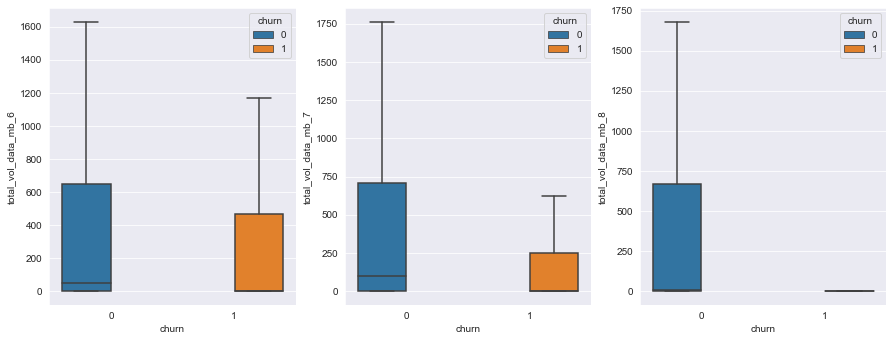

In [81]:
#Total Data plot
churn_boxplot("total_vol_data_mb_")

Usage of internet is decreasing 

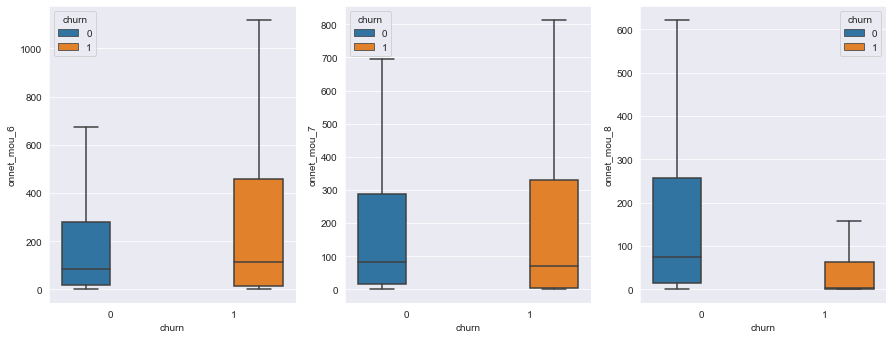

In [82]:
#onnet_mou_
churn_boxplot("onnet_mou_")

#### Treating Outliers

In [38]:
outlier_col = high_value_cust_data.drop(['churn'], axis=1)
def drop_outliers(x):
    list = []
    for col in outlier_col:
        Q1 = x[col].quantile(.01)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   
high_value_cust_data = drop_outliers(high_value_cust_data)

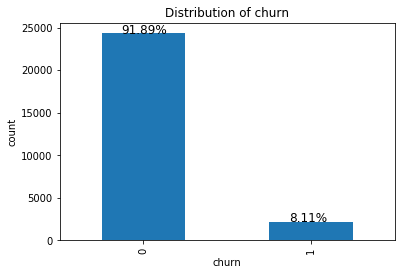

In [39]:
# %age of churn and non churn customers
ax = count_plot("churn")
display_values(ax)

After removing outliers there is slight change in the %age of churn customers

### Data Modelling

#### PCA

In [40]:
# creating copy of the final hv_user dataframe
high_value_cust_data_PCA = high_value_cust_data.copy()

In [41]:
#putting features variables in X
X = high_value_cust_data_PCA.drop(['churn'], axis=1)

#putting response variables in Y
y = high_value_cust_data_PCA['churn']    

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [42]:
scaler = MinMaxScaler()
# fitting and transforming the scaler on train
X_train = scaler.fit_transform(X_train)
# transforming the train using the already fit scaler
X_test = scaler.transform(X_test)

#### Class imbalance

In [88]:
# ?SMOTE

In [43]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [44]:
#Importing the PCA module
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [91]:
pca.explained_variance_ratio_

array([3.71170112e-01, 9.02707801e-02, 5.86710786e-02, 4.99152014e-02,
       4.48106647e-02, 4.24530201e-02, 2.25337177e-02, 2.12198941e-02,
       1.97067340e-02, 1.83725429e-02, 1.34270492e-02, 1.31540031e-02,
       1.18353524e-02, 1.03448550e-02, 9.76340915e-03, 8.92721343e-03,
       8.59965175e-03, 8.01584694e-03, 7.61692282e-03, 6.96583814e-03,
       6.70773231e-03, 6.32851429e-03, 5.65730875e-03, 5.35341419e-03,
       5.11133808e-03, 4.85456409e-03, 4.38095842e-03, 4.35485931e-03,
       4.28860764e-03, 4.12622021e-03, 3.90079484e-03, 3.60408206e-03,
       3.48402666e-03, 3.38066813e-03, 3.21001903e-03, 3.12324092e-03,
       2.96276365e-03, 2.93840511e-03, 2.82676392e-03, 2.78628647e-03,
       2.66738102e-03, 2.44168789e-03, 2.42890757e-03, 2.35495536e-03,
       2.31767320e-03, 2.26854374e-03, 2.22012037e-03, 2.16293750e-03,
       2.15522163e-03, 2.13640475e-03, 2.02115908e-03, 1.98426564e-03,
       1.91403320e-03, 1.84881239e-03, 1.75281982e-03, 1.74294202e-03,
      

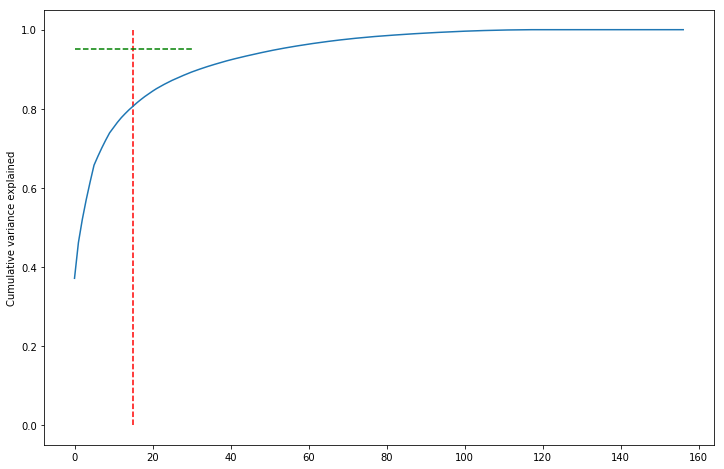

In [45]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [46]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
pca_final = IncrementalPCA(n_components=45)

In [47]:
X_train_pca = pca_final.fit_transform(X_train)
X_train_pca.shape

(34026, 45)

In [48]:
# max corr: 0.012369584235697997 , min corr:  -0.011934392799332038
corrmat = np.corrcoef(X_train_pca.transpose())
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.01236958423570142 , min corr:  -0.01193439279932764


In [49]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(7942, 45)

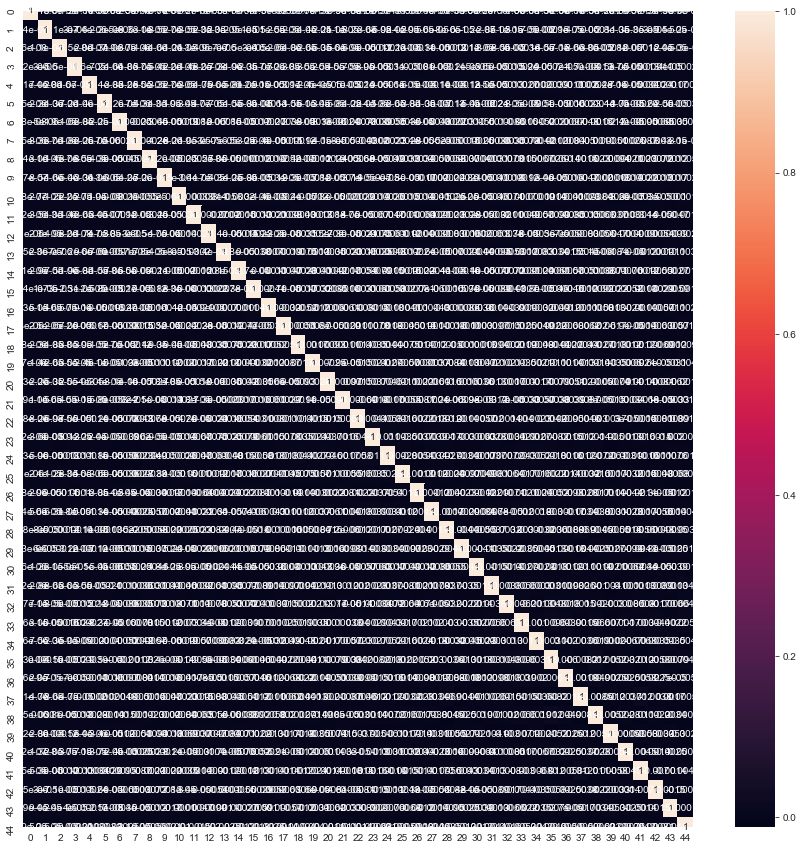

In [97]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

In [50]:
# probability cutoff function
def churn_predict_prob(model,X,y,prob):
    pred_probs = model.predict_proba(X)[:,1]
    
    y_trn_df= pd.DataFrame({'churn':y, 'churn_Prob':pred_probs})
    # Creating new column 'predicted' with 1 if Churn_Prob>prob else 0
    y_trn_df['final_predicted'] = y_trn_df.churn_Prob.map( lambda x: 1 if x > prob else 0)
    getModelMetrics(y_trn_df.churn,y_trn_df.final_predicted)
    return y_trn_df

In [51]:
def getModelMetrics(actual_churn=False,pred_churn=False):

    confusion = metrics.confusion_matrix(actual_churn, pred_churn)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    print("Roc_auc_score : {}".format(metrics.roc_auc_score(actual_churn,pred_churn)))
    print('Sensitivity/Recall : {}'.format(TP / float(TP+FN)))
    print('Specificity: {}'.format(TN / float(TN+FP)))
    print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
    print('Positive predictive value: {}'.format(TP / float(TP+FP)))
    print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))
    print('sklearn precision score value: {}'.format(metrics.precision_score(actual_churn, pred_churn )))

In [52]:
def findCutoff(df):
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i] = df.churn_Prob.map( lambda x: 1 if x > i else 0)
    
    probabilities = [i/10 for i in range(10) ]
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    
    for i in probabilities:
        cm1 = metrics.confusion_matrix(df.churn, df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

#### Logistic Reg

In [53]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca, y_train)

In [54]:
# Accuracy : 0.8315
# Recall/Sensitivity : 0.8488
# AUC Score (Train): 0.904972 
#Predict training set:
dtrain_predictions = learner_pca.predict(X_train_pca)
dtrain_predprob = learner_pca.predict_proba(X_train_pca)[:,1]
print ("Accuracy : %.4g" % metrics.roc_auc_score(y_train, dtrain_predictions))
print ("Recall/Sensitivity : %.4g" % metrics.recall_score(y_train, dtrain_predictions))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

Accuracy : 0.8441
Recall/Sensitivity : 0.8533
AUC Score (Train): 0.912467


In [55]:
#test set
pred_test = model_pca.predict(X_test_pca)
pred_probs_test = model_pca.predict_proba(X_test_pca)
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

'0.89'

In [56]:
getModelMetrics(y_test,pred_test)

Roc_auc_score : 0.8248984701112659
Sensitivity/Recall : 0.8171701112877583
Specificity: 0.8326268289347737
False Positive Rate: 0.1673731710652263
Positive predictive value: 0.2957422324510932
Negative Predictive value: 0.9814635718891038
sklearn precision score value: 0.2957422324510932


In [57]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7313
           1       0.30      0.82      0.43       629

    accuracy                           0.83      7942
   macro avg       0.64      0.82      0.67      7942
weighted avg       0.93      0.83      0.86      7942



In [58]:
# [[6702 1603]
#  [ 115  566]]
# Printing confusion matrix
print(confusion_matrix(y_test,pred_test))

[[6089 1224]
 [ 115  514]]


##### We want our recall value to be as high as possible so that we do not miss on any customer who has tendency to churn

In [59]:
#hyper tuning
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=learner_pca,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(X_train_pca, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.1min finished


Best Score:  0.9118589001621735
Best Params:  {'C': 1000, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l1', 'solver': 'saga'}


In [60]:
lr = LogisticRegression(C=1000,class_weight={1: 0.4, 0: 0.6}, penalty='l1', solver='saga',random_state=10)

In [61]:
lr_model = lr.fit(X_train_pca, y_train)

In [62]:
lr_pred = lr_model.predict(X_test_pca)
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
getModelMetrics(y_test,lr_pred)

Roc_auc_score : 0.8350241756464358
Sensitivity/Recall : 0.7869634340222575
Specificity: 0.883084917270614
False Positive Rate: 0.11691508272938603
Positive predictive value: 0.36666666666666664
Negative Predictive value: 0.9796723300970874
sklearn precision score value: 0.36666666666666664


In [64]:
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7313
           1       0.37      0.79      0.50       629

    accuracy                           0.88      7942
   macro avg       0.67      0.84      0.71      7942
weighted avg       0.93      0.88      0.89      7942



In [65]:
print(confusion_matrix(y_test,lr_pred))

[[6458  855]
 [ 134  495]]


In [114]:
#False negative has increased 
#We see decrease in Recall. Will consider  initial model with cut off 0.5 

In [66]:
# predict
prob_result_df = churn_predict_prob(model_pca,X_test_pca,y_test,0.5)


Roc_auc_score : 0.8248984701112659
Sensitivity/Recall : 0.8171701112877583
Specificity: 0.8326268289347737
False Positive Rate: 0.1673731710652263
Positive predictive value: 0.2957422324510932
Negative Predictive value: 0.9814635718891038
sklearn precision score value: 0.2957422324510932


In [116]:
prob_result_df.head(30)

,churn,churn_Prob,final_predicted
1544,0,0.006769,0
28039,0,0.313325,0
11943,0,0.010410,0
10873,0,0.015404,0
1053,0,0.368398,0
14512,0,0.738583,1
18502,0,0.418114,0
23340,0,0.058323,0
14755,0,0.280645,0
21564,0,0.017406,0


In [117]:
# ?BinaryClassification

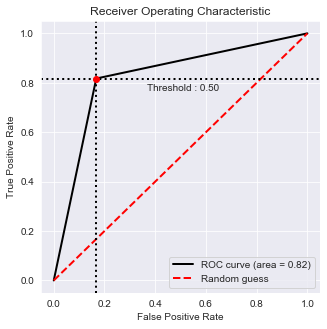

In [118]:
# Visualisation with plot_metric

bc = BinaryClassification(prob_result_df.churn, prob_result_df.final_predicted, labels=["Class 1", "Class 2"],threshold=0.5)

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

     prob  accuracy     sensi     speci
0.0   0.0  0.079199  1.000000  0.000000
0.1   0.1  0.482246  0.958665  0.441269
0.2   0.2  0.619995  0.917329  0.594421
0.3   0.3  0.707378  0.885533  0.692055
0.4   0.4  0.778393  0.853736  0.771913
0.5   0.5  0.831277  0.817170  0.832490
0.6   0.6  0.876857  0.788553  0.884452
0.7   0.7  0.900781  0.710652  0.917134
0.8   0.8  0.920549  0.634340  0.945166
0.9   0.9  0.927096  0.348172  0.976890


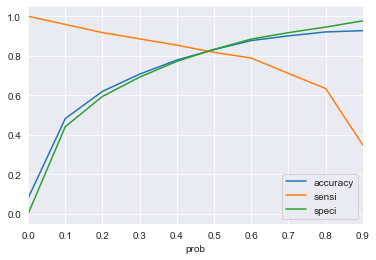

In [119]:
findCutoff(prob_result_df)

In [120]:
#from plot we can consider 0.45 cutoff  

In [121]:
# predict
prob_result_df_test = churn_predict_prob(model_pca,X_test_pca,y_test,0.45)

Roc_auc_score : 0.817036520759142
Sensitivity/Recall : 0.8298887122416534
Specificity: 0.8041843292766306
False Positive Rate: 0.19581567072336933
Positive predictive value: 0.2671443193449335
Negative Predictive value: 0.9821309285237141
sklearn precision score value: 0.2671443193449335


In [122]:
# predict
prob_result_train = churn_predict_prob(model_pca,X_train_pca,y_train,0.45)

Roc_auc_score : 0.8392405807323812
Sensitivity/Recall : 0.8755069652618586
Specificity: 0.8029741962029037
False Positive Rate: 0.19702580379709633
Positive predictive value: 0.816298569627884
Negative Predictive value: 0.8657709614043982
sklearn precision score value: 0.816298569627884


Train data: Sensitivity/ Recall 87% |
Test data: Sensitivity/ Recall 83%
ROC Curve 82%

#### Random forest

In [123]:
#default 
rfc = RandomForestClassifier()

In [124]:
rfc.fit(X_train_pca,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
# Making predictions
predictions = rfc.predict(X_test_pca)

In [126]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7313
           1       0.43      0.46      0.45       629

    accuracy                           0.91      7942
   macro avg       0.69      0.70      0.70      7942
weighted avg       0.91      0.91      0.91      7942



In [127]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[6933  380]
 [ 339  290]]


Hyper parameter tuning
* Max depth
* n_estimator
* max features
* min sample leaf
* min sample split

processing takes time

In [128]:
 #Max depth

# GridSearchCV to find optimal max_features

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1",return_train_score=True)
rf.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [129]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.285569,0.028009,0.006944,0.000914,2,{'max_depth': 2},0.770480,0.783819,0.774968,0.770632,0.776636,0.775307,0.004889,4,0.784417,0.787121,0.768392,0.778830,0.777258,0.779203,0.006491
1,0.846001,0.086217,0.009260,0.001375,7,{'max_depth': 7},0.824934,0.848764,0.844386,0.828254,0.844968,0.838261,0.009701,3,0.855410,0.854293,0.853104,0.844364,0.850923,0.851619,0.003920
2,1.290267,0.112470,0.013114,0.001584,12,{'max_depth': 12},0.904413,0.909245,0.912619,0.907563,0.915323,0.909832,0.003815,2,0.952517,0.942153,0.952821,0.949755,0.950981,0.949645,0.003905
3,1.675207,0.268086,0.017390,0.008319,17,{'max_depth': 17},0.926231,0.940063,0.934026,0.935368,0.937780,0.934693,0.004709,1,0.980137,0.981605,0.982342,0.982485,0.979097,0.981133,0.001315


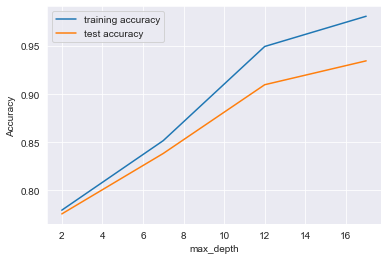

In [130]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [131]:
#tuning n estimators
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(50, 150, 25)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=12,random_state=10)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1",return_train_score=True)

rf.fit(X_train_pca, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_

In [132]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.360571,0.488503,0.044703,0.006348,50,{'n_estimators': 50},0.911149,0.922923,0.922856,0.919189,0.922169,0.919657,0.004468,4,0.955785,0.955895,0.959418,0.957789,0.956394,0.957056,0.001380
1,9.726692,0.888374,0.070321,0.006055,75,{'n_estimators': 75},0.912502,0.923737,0.923033,0.920617,0.920717,0.920121,0.004005,3,0.956500,0.957149,0.960112,0.958459,0.957212,0.957886,0.001281
2,11.300350,0.385638,0.076244,0.002344,100,{'n_estimators': 100},0.915113,0.925629,0.924490,0.920789,0.921994,0.921603,0.003674,2,0.957285,0.957812,0.960057,0.958702,0.957842,0.958340,0.000972
3,13.862823,0.029125,0.095406,0.004804,125,{'n_estimators': 125},0.914851,0.927744,0.925330,0.921406,0.923320,0.922530,0.004379,1,0.958187,0.958681,0.960728,0.959149,0.958934,0.959136,0.000858


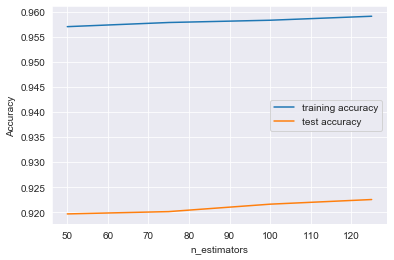

In [133]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [134]:
#Takes times

In [135]:
#tuning max featues
parameters = {'max_features': [4, 8, 14, 20, 24]}
rf = RandomForestClassifier(random_state=10)
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1",return_train_score=True)
rf.fit(X_train_pca,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [136]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.061671,0.015903,0.013760,0.000425,4,{'max_features': 4},0.936844,0.940173,0.935360,0.939682,0.942393,0.938890,0.002498,5,0.997794,0.998530,0.997832,0.998493,0.998310,0.998192,0.000318
1,2.089688,0.085794,0.013120,0.000111,8,{'max_features': 8},0.941451,0.945023,0.940694,0.939840,0.941055,0.941613,0.001786,1,0.998125,0.998199,0.998236,0.998162,0.998310,0.998206,0.000064
2,3.741195,0.058163,0.013446,0.000391,14,{'max_features': 14},0.938644,0.944696,0.944192,0.940129,0.940108,0.941554,0.002426,2,0.997757,0.997832,0.997905,0.997868,0.998016,0.997875,0.000086
3,5.563939,0.508662,0.012921,0.000246,20,{'max_features': 20},0.935583,0.945780,0.937564,0.938448,0.939643,0.939404,0.003453,4,0.997977,0.997942,0.997941,0.998015,0.997612,0.997898,0.000145
4,6.595081,0.149364,0.013101,0.000469,24,{'max_features': 24},0.937775,0.944282,0.940488,0.942361,0.937307,0.940443,0.002660,3,0.997905,0.998200,0.998199,0.997832,0.998162,0.998060,0.000158


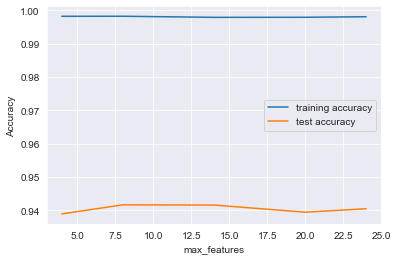

In [137]:
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [138]:
parameters = {'min_samples_leaf': range(100, 400, 50)}
rf = RandomForestClassifier(random_state=10)
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1",return_train_score=True)
rf.fit(X_train_pca,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [139]:
scores = rf.cv_results_

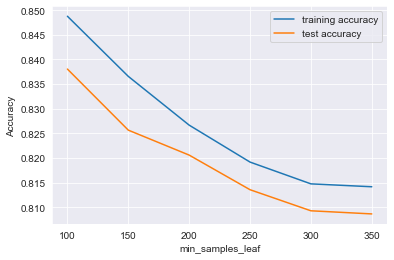

In [140]:
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [141]:
#min sample split
parameters = {'min_samples_split': range(50, 300, 50)}
rf = RandomForestClassifier(random_state=10)
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1",return_train_score=True)
rf.fit(X_train_pca,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=10,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [142]:
scores = rf.cv_results_


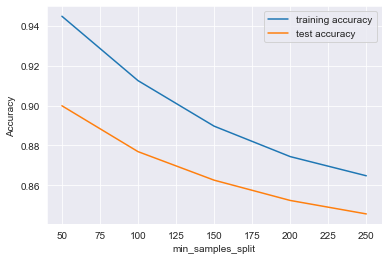

In [143]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [144]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10,12],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(50, 300, 50),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1,verbose = 1)

In [145]:
# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 158.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [146]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8445012637394933 using {'max_depth': 12, 'max_features': 5, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 200}


In [147]:
rf_final = RandomForestClassifier(max_depth=12,
                                  n_estimators=200,
                                  max_features=5,
                                  min_samples_leaf=100,
                                  min_samples_split=100,
                                  random_state=10)

In [148]:
# fit
rf_final.fit(X_train_pca,y_train)
# predict
predictions = rf_final.predict(X_test_pca)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [149]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7313
           1       0.32      0.71      0.44       629

    accuracy                           0.86      7942
   macro avg       0.64      0.79      0.68      7942
weighted avg       0.92      0.86      0.88      7942



In [150]:
getModelMetrics(y_test,predictions)

Roc_auc_score : 0.78803117996416
Sensitivity/Recall : 0.7074721780604134
Specificity: 0.8685901818679065
False Positive Rate: 0.13140981813209354
Positive predictive value: 0.31650071123755336
Negative Predictive value: 0.9718482252141983
sklearn precision score value: 0.31650071123755336


In [151]:
prob_result_df = churn_predict_prob(rf_final,X_test_pca,y_test,0.5)


Roc_auc_score : 0.78803117996416
Sensitivity/Recall : 0.7074721780604134
Specificity: 0.8685901818679065
False Positive Rate: 0.13140981813209354
Positive predictive value: 0.31650071123755336
Negative Predictive value: 0.9718482252141983
sklearn precision score value: 0.31650071123755336


     prob  accuracy     sensi     speci
0.0   0.0  0.079199  1.000000  0.000000
0.1   0.1  0.132838  0.995231  0.058663
0.2   0.2  0.442710  0.974563  0.396964
0.3   0.3  0.660917  0.906200  0.639819
0.4   0.4  0.787585  0.820350  0.784767
0.5   0.5  0.855830  0.707472  0.868590
0.6   0.6  0.897255  0.583466  0.924244
0.7   0.7  0.915764  0.410175  0.959251
0.8   0.8  0.921808  0.203498  0.983591
0.9   0.9  0.920171  0.039746  0.995898


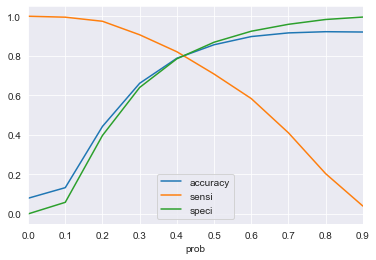

In [152]:
findCutoff(prob_result_df)

Lets decrease cutoff value  to 0.45 to achieve high sensitivity 

In [153]:
# test set
prob_result_df = churn_predict_prob(rf_final,X_test_pca,y_test,0.4)

Roc_auc_score : 0.8025583075373537
Sensitivity/Recall : 0.8203497615262321
Specificity: 0.7847668535484753
False Positive Rate: 0.2152331464515247
Positive predictive value: 0.24688995215311005
Negative Predictive value: 0.9806903622693096
sklearn precision score value: 0.24688995215311005


In [154]:
#train set
res = churn_predict_prob(rf_final,X_train_pca,y_train,0.45)

Roc_auc_score : 0.8649268206665491
Sensitivity/Recall : 0.889378710397931
Specificity: 0.8404749309351672
False Positive Rate: 0.15952506906483277
Positive predictive value: 0.8479125805547773
Negative Predictive value: 0.8836907484086274
sklearn precision score value: 0.8479125805547773


Train set: recall = 88%, specificity = 84% |
Test set: recall 82%, specificity = 78%

#### XGboost

In [341]:
# ?XGBClassifier

In [67]:
model = XGBClassifier()

In [68]:
model.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [69]:
y_pred = model.predict_proba(X_test_pca)
y_pred[:10]

array([[9.9941254e-01, 5.8744557e-04],
       [9.9918735e-01, 8.1264495e-04],
       [9.9875319e-01, 1.2468024e-03],
       [9.9986970e-01, 1.3031384e-04],
       [7.6491773e-01, 2.3508230e-01],
       [2.7362943e-01, 7.2637057e-01],
       [9.2857319e-01, 7.1426794e-02],
       [9.9741060e-01, 2.5893950e-03],
       [9.5503551e-01, 4.4964507e-02],
       [9.9743736e-01, 2.5626228e-03]], dtype=float32)

In [70]:
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 86.93%


In [71]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9],
             }          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [72]:
# fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [73]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.648342,0.108259,0.028669,0.000473,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.930681,0.940055,0.938083,0.936273,0.004035,6,0.950350,0.946646,0.947112,0.948036,0.001647
1,3.596011,0.387003,0.029002,0.000816,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.931878,0.941270,0.937884,0.937011,0.003883,4,0.951901,0.947841,0.947776,0.949172,0.001930
2,3.760014,0.075529,0.030001,0.002160,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.930253,0.940748,0.938202,0.936401,0.004470,5,0.952292,0.948852,0.948859,0.950001,0.001620
3,2.583009,0.090410,0.028334,0.000473,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.934046,0.938325,0.939672,0.937348,0.002398,3,0.965398,0.959451,0.961043,0.961964,0.002513
4,3.663679,0.234360,0.029668,0.002358,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.943801,0.950423,0.946155,0.946793,0.002741,2,0.972012,0.969549,0.968561,0.970041,0.001451
5,4.133682,0.239258,0.032334,0.003772,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.943471,0.951667,0.949674,0.948271,0.003490,1,0.973030,0.970187,0.970674,0.971297,0.001241


In [74]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.648342,0.108259,0.028669,0.000473,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.930681,0.940055,0.938083,0.936273,0.004035,6,0.950350,0.946646,0.947112,0.948036,0.001647
1,3.596011,0.387003,0.029002,0.000816,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.931878,0.941270,0.937884,0.937011,0.003883,4,0.951901,0.947841,0.947776,0.949172,0.001930
2,3.760014,0.075529,0.030001,0.002160,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.930253,0.940748,0.938202,0.936401,0.004470,5,0.952292,0.948852,0.948859,0.950001,0.001620
3,2.583009,0.090410,0.028334,0.000473,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.934046,0.938325,0.939672,0.937348,0.002398,3,0.965398,0.959451,0.961043,0.961964,0.002513
4,3.663679,0.234360,0.029668,0.002358,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.943801,0.950423,0.946155,0.946793,0.002741,2,0.972012,0.969549,0.968561,0.970041,0.001451


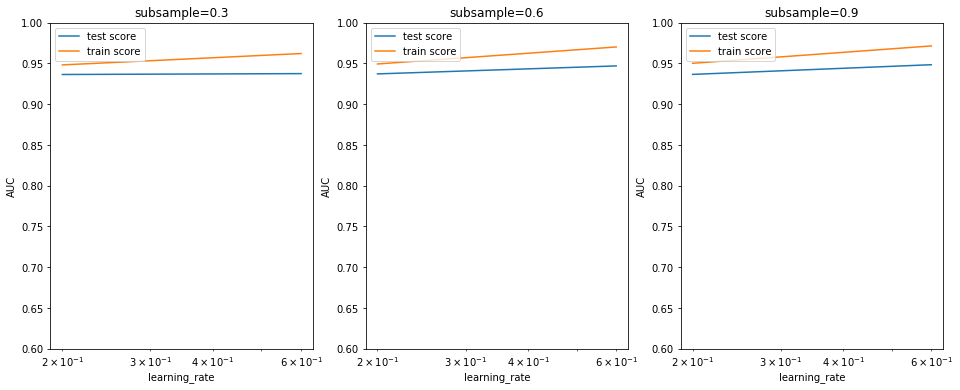

In [75]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [76]:
model_cv.best_params_, model_cv.best_score_

({'learning_rate': 0.6, 'subsample': 0.9}, 0.9482707286511524)

In [77]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'max_depth':range(3,10,2)
             }          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [78]:
# fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [79]:
model_cv.best_params_, model_cv.best_score_

({'max_depth': 9}, 0.9906671978401324)

In [80]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.6,
          'max_depth': 9, 
          'n_estimators':150,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train_pca, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.6, 'max_depth': 9, 'n_estimators': 150,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [81]:
# predict
y_pred = model.predict_proba(X_test_pca)
y_pred[:10]

array([[9.9941254e-01, 5.8744557e-04],
       [9.9918735e-01, 8.1264495e-04],
       [9.9875319e-01, 1.2468024e-03],
       [9.9986970e-01, 1.3031384e-04],
       [7.6491773e-01, 2.3508230e-01],
       [2.7362943e-01, 7.2637057e-01],
       [9.2857319e-01, 7.1426794e-02],
       [9.9741060e-01, 2.5893950e-03],
       [9.5503551e-01, 4.4964507e-02],
       [9.9743736e-01, 2.5626228e-03]], dtype=float32)

In [82]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
auc

0.8693286798755705

In [83]:
xg_predictions = model.predict(X_test_pca)

In [84]:
getModelMetrics(y_test,xg_predictions)

Roc_auc_score : 0.7607952343073521
Sensitivity/Recall : 0.589825119236884
Specificity: 0.9317653493778203
False Positive Rate: 0.06823465062217968
Positive predictive value: 0.4264367816091954
Negative Predictive value: 0.9635180995475113
sklearn precision score value: 0.4264367816091954


In [85]:
#train set
prob_result_df_train = churn_predict_prob(model,X_train_pca,y_train,0.5)


Roc_auc_score : 0.9914771057426673
Sensitivity/Recall : 0.9982954211485334
Specificity: 0.9846587903368013
False Positive Rate: 0.01534120966319873
Positive predictive value: 0.9848651783125544
Negative Predictive value: 0.998271855074191
sklearn precision score value: 0.9848651783125544


In [86]:
#test
prob_result_df1 = churn_predict_prob(model,X_test_pca,y_test,0.5)


Roc_auc_score : 0.7607952343073521
Sensitivity/Recall : 0.589825119236884
Specificity: 0.9317653493778203
False Positive Rate: 0.06823465062217968
Positive predictive value: 0.4264367816091954
Negative Predictive value: 0.9635180995475113
sklearn precision score value: 0.4264367816091954


     prob  accuracy     sensi     speci
0.0   0.0  0.079199  1.000000  0.000000
0.1   0.1  0.783178  0.791733  0.782442
0.2   0.2  0.842987  0.732909  0.852455
0.3   0.3  0.872450  0.680445  0.888965
0.4   0.4  0.889952  0.631161  0.912211
0.5   0.5  0.904684  0.589825  0.931765
0.6   0.6  0.912491  0.534181  0.945029
0.7   0.7  0.918157  0.470588  0.956653
0.8   0.8  0.925082  0.402226  0.970053
0.9   0.9  0.927474  0.278219  0.983317


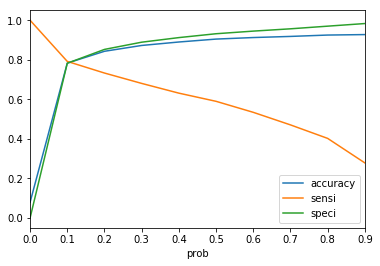

In [87]:
findCutoff(prob_result_df1)

In [88]:
prob_result_df1 = churn_predict_prob(model,X_train_pca,y_train,0.1)


Roc_auc_score : 0.9324046317521896
Sensitivity/Recall : 1.0
Specificity: 0.864809263504379
False Positive Rate: 0.135190736495621
Positive predictive value: 0.8809092321234402
Negative Predictive value: 1.0
sklearn precision score value: 0.8809092321234402


In [89]:
prob_result_df1.head(30)

,churn,churn_Prob,final_predicted
0,0,0.002035,0
1,0,0.334671,1
2,0,0.077831,0
3,0,0.017331,0
4,1,0.872880,1
5,0,0.001881,0
6,0,0.000208,0
7,1,0.978350,1
8,0,0.109164,1
9,0,0.009626,0


In [90]:
prob_result_df1 = churn_predict_prob(model,X_test_pca,y_test,0.2)


Roc_auc_score : 0.7926819564957932
Sensitivity/Recall : 0.7329093799682035
Specificity: 0.852454533023383
False Positive Rate: 0.147545466976617
Positive predictive value: 0.29935064935064937
Negative Predictive value: 0.9737582005623243
sklearn precision score value: 0.29935064935064937


Sensitivty/ Recall on test data is 79%    
Sensitivty/ Recall on train data is 99%

#### Best Fit model

Logistic Regression model seems to perform best among the three models with Train as well as Test data    
**Train data: Sensitivity/ Recall 84%** |    
**Test data: Sensitivity/ Recall 83%** |    
**ROC Curve 82%**

### Logistic Regression model with RFE for Variable recommendation

In [180]:
# creating copy of the final hv_user dataframe for RFE
high_value_cust_data_RFE = high_value_cust_data.copy()

In [181]:
#putting features variables in X
X_rfe = high_value_cust_data_RFE.drop(['churn'], axis=1)

#putting response variables in Y
y_rfe = high_value_cust_data_RFE['churn']    

# Splitting the data into train and test
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe,y_rfe, train_size=0.7,test_size=0.3,random_state=100)

y_train_rfe = y_train_rfe.values.reshape(-1,1)

#### Scale the train and test data using MinMaxScaler

In [182]:
scaler = MinMaxScaler()
# fitting and transforming the scaler on train
X_train_scaled_transformed = scaler.fit_transform(X_train_rfe)
# transforming the train using the already fit scaler
X_test_transformed = scaler.transform(X_test_rfe)

In [183]:
X_train_rfe = pd.DataFrame(X_train_scaled_transformed, columns = X_train_rfe.columns)
X_test_rfe = pd.DataFrame(X_test_transformed, columns = X_test_rfe.columns)

#### Lets perform RFE to select top 45 features since PCA shrunk the features to that number

In [184]:
# Create Logic regression model
logreg = LogisticRegression()

# Execute RFE with aim to select top 45 most impacting features 
rfe = RFE(logreg, 45)
rfe = rfe.fit(X_train_rfe, y_train_rfe)

In [185]:
list(zip(X_train_rfe.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('onnet_mou_6', False, 100),
 ('onnet_mou_7', False, 73),
 ('onnet_mou_8', False, 12),
 ('offnet_mou_6', False, 35),
 ('offnet_mou_7', False, 72),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 48),
 ('roam_ic_mou_7', True, 1),
 ('roam_ic_mou_8', False, 44),
 ('roam_og_mou_6', False, 76),
 ('roam_og_mou_7', False, 9),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 56),
 ('loc_og_t2t_mou_7', True, 1),
 ('loc_og_t2t_mou_8', False, 17),
 ('loc_og_t2m_mou_6', False, 34),
 ('loc_og_t2m_mou_7', False, 7),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 84),
 ('loc_og_t2f_mou_7', False, 52),
 ('loc_og_t2f_mou_8', False, 18),
 ('loc_og_t2c_mou_6', False, 27),
 ('loc_og_t2c_mou_7', False, 87),
 ('loc_og_t2c_mou_8', False, 24),
 ('loc_og_mou_6', False, 109),
 ('loc_og_mou_7', False, 107),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 93),
 ('std_og_t2t_mou_7', False, 108),
 ('std_og_t2t_m

In [216]:
col = X_train_rfe.columns[rfe.support_]
col

Index(['arpu_6', 'arpu_7', 'arpu_8', 'offnet_mou_8', 'roam_ic_mou_7',
       'roam_og_mou_8', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_8', 'loc_og_mou_8',
       'std_og_t2m_mou_7', 'std_og_t2f_mou_8', 'isd_og_mou_7',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_7',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'total_rech_data_8', 'count_rech_2g_8',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'arpu_2g_6', 'monthly_2g_7',
       'sachet_2g_6', 'sachet_3g_7', 'fb_user_8', 'aon', 'vbc_3g_8',
       'total_data_rech_amt_8'],
      dtype='object')

#### Regression using StatsModel:

##### Helper Functions

In [187]:
# Perform stats model linear regression on the data set.
# Returns original dataset with added constant and regression fit results.
def stats_model_assessment(X_train_df, displaySummary=False):
    X_train_sm = stm.add_constant(X_train_df)
    logm = stm.GLM(y_train_rfe,X_train_sm, family = stm.families.Binomial())
    res = logm.fit()
    if(displaySummary):
        print(res.summary(), "\n\n")
    return X_train_sm, res;

In [188]:
# Performs prediction on the training dataset. Uses y_train to populate churn data.
def get_churn_prediction_data(X_train_df, res, displaySummary=False):
    # Getting the predicted values on the train set
    y_train_pred = res.predict(X_train_df)
    y_train_pred = y_train_pred.values.reshape(-1)
    y_train_pred_df = pd.DataFrame({'Churn':y_train_rfe.ravel(), 'Churn_Prob':y_train_pred})
    y_train_pred_df['Predicted'] = y_train_pred_df.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
    if(displaySummary):
        print("Prediction Data on training set : \n", y_train_pred_df.head(), "\n\n")
    return y_train_pred_df

In [189]:
# Performs GLM regression on the dataset provided, performs prediction and computes accuracy score.
# Returns accuracy score
def perform_accuracy_assessment_using_statsmodel(X_train_df, displayAllSummary=False):
    X_train_sm, res = stats_model_assessment(X_train_df, displayAllSummary)
    y_train_pred_df = get_churn_prediction_data(X_train_sm, res, displayAllSummary)
    if(displayAllSummary):
        confusion = metrics.confusion_matrix(y_train_pred_df.Churn, y_train_pred_df.Predicted )
        print("Confustion Matrix :\n", confusion, "\n\n")
        # Display the overall accuracy.
        print("Accuracy Score : ", metrics.accuracy_score(y_train_pred_df.Churn, y_train_pred_df.Predicted), "\n\n")
    
    return metrics.accuracy_score(y_train_pred_df.Churn, y_train_pred_df.Predicted)

In [190]:
# Method to help with computing VIF on the provided dataset.
# Returns VIF dataframe
def compute_vif(X_train_df):
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = X_train_df.columns
    vif['VIF'] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif = vif.reset_index(drop=True)
    return vif

In [191]:
# Method to help in iteratively perform VIF calculations on the data set.
# With every iteration removes one variable with highest VIF score.
# Exits the iterator on two conditions, 
#.    1. If obtained accuracy score of the model goes below the specified accuracy limit.
#.    2. If all variables having the VIF greater then specified VIF limit are removed.
# Returns the dataset with removed columns.
def iterative_vif_till_limit(X_train_df, vifLimit=5.0, accuracy_lower_limit=-1, iterationCount=1):
    print("Iteration : ", iterationCount)
    
    if(accuracy_lower_limit != -1):
        accuracy_score = perform_accuracy_assessment_using_statsmodel(X_train_df)
        print(", Accuracy Score : ", accuracy_score)
        if(accuracy_score < accuracy_lower_limit):
            print(", Exiting For Accuracy limit.\n")
            return X_train_df
    
    vif = compute_vif(X_train_df)
    if(vif.loc[0,'VIF']>vifLimit):
        print(", Drop Feature : ", vif.loc[0,'Features'], ", VIF : ", vif.loc[0,'VIF'], "\n")
        X_train_df = X_train_df.drop(vif.loc[0,'Features'], 1)
        return iterative_vif_till_limit(X_train_df, vifLimit, accuracy_lower_limit, iterationCount+1)
    else:
        print("\n", vif)
        return X_train_df
    

In [217]:
perform_accuracy_assessment_using_statsmodel(X_train_rfe[col], True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18530
Model:                            GLM   Df Residuals:                    18484
Model Family:                Binomial   Df Model:                           45
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3235.0
Date:                Mon, 18 May 2020   Deviance:                       6470.1
Time:                        14:13:39   Pearson chi2:                 2.43e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.30

0.9365893146249326

There are quite a few columns with high p-values. Let's look at VIF values.

In [218]:
compute_vif(X_train_rfe[col])

,Features,VIF
0,loc_ic_mou_8,2.771877e+09
1,loc_ic_t2m_mou_8,1.477150e+09
2,loc_ic_t2t_mou_8,3.061745e+08
3,loc_ic_t2f_mou_8,2.848268e+07
4,total_ic_mou_8,4.130800e+02
5,std_ic_mou_8,1.918400e+02
6,std_ic_t2m_mou_8,9.784000e+01
7,arpu_8,8.025000e+01
8,arpu_6,7.886000e+01
9,arpu_7,7.345000e+01


There are a lot of variables with very high VIF scores.

In [219]:
# First remove attributes with very high VIF values start with a cutoff of 10.0 in an iterative manner.
# Use a accuracy threshold of 90% to exit iterator if VIF threshold of 10 is not met to review the output.
X_train_final = iterative_vif_till_limit(X_train_rfe[col], 10.0, 0.90)

Iteration :  1
, Accuracy Score :  0.9365893146249326
, Drop Feature :  loc_ic_mou_8 , VIF :  2771876631.52 

Iteration :  2
, Accuracy Score :  0.9335132218024824
, Drop Feature :  total_ic_mou_8 , VIF :  412.92 

Iteration :  3
, Accuracy Score :  0.9335132218024824
, Drop Feature :  std_ic_mou_8 , VIF :  174.29 

Iteration :  4
, Accuracy Score :  0.9335132218024824
, Drop Feature :  arpu_8 , VIF :  79.71 

Iteration :  5
, Accuracy Score :  0.9333513221802483
, Drop Feature :  arpu_7 , VIF :  70.27 

Iteration :  6
, Accuracy Score :  0.9335132218024824
, Drop Feature :  total_rech_data_8 , VIF :  45.14 

Iteration :  7
, Accuracy Score :  0.9335132218024824
, Drop Feature :  loc_og_mou_8 , VIF :  23.61 

Iteration :  8
, Accuracy Score :  0.9338909875876956
, Drop Feature :  arpu_6 , VIF :  22.74 

Iteration :  9
, Accuracy Score :  0.9334592552617377
, Drop Feature :  total_rech_amt_8 , VIF :  12.82 

Iteration :  10
, Accuracy Score :  0.9332433890987588

                  Featu

In [220]:
# Check the regression results after removing variables with high VIF of more than 10.0.
perform_accuracy_assessment_using_statsmodel(X_train_final, True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18530
Model:                            GLM   Df Residuals:                    18493
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3294.2
Date:                Mon, 18 May 2020   Deviance:                       6588.3
Time:                        14:14:44   Pearson chi2:                 5.21e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.63

0.9332433890987588

offnet_mou_8 has a p-value 0.396 and count_rech_2g_8 has high p-value of 0.329.

Since there are more variables with VIF value over 5.0, lets remove those variables first and review regression results again.

In [221]:
# Remove attributes with high VIF values with a cutoff of 5.0 in an iterative manner.
# Use a accuracy threshold of 90% to exit iterator if VIF threshold of 5.0 is not met to review the output again.
# Remove the high p-values after eliminating variables with high VIF.

X_train_final = iterative_vif_till_limit(X_train_final, 5.0, 0.90)

Iteration :  1
, Accuracy Score :  0.9332433890987588
, Drop Feature :  total_ic_mou_7 , VIF :  9.47 

Iteration :  2
, Accuracy Score :  0.9329735563950351
, Drop Feature :  offnet_mou_8 , VIF :  8.97 

Iteration :  3
, Accuracy Score :  0.9331354560172693
, Drop Feature :  total_rech_amt_7 , VIF :  7.48 

Iteration :  4
, Accuracy Score :  0.9341068537506746

                  Features   VIF
0        total_rech_amt_6  4.57
1          total_ic_mou_6  4.57
2          total_og_mou_8  4.29
3         count_rech_2g_8  3.89
4               fb_user_8  3.55
5        loc_ic_t2m_mou_8  3.53
6        total_rech_num_8  3.28
7   total_data_rech_amt_8  2.81
8        loc_og_t2m_mou_8  2.80
9                     aon  2.20
10            vol_2g_mb_8  2.11
11            vol_2g_mb_7  2.10
12       std_ic_t2t_mou_8  2.09
13     last_day_rch_amt_8  2.01
14       std_ic_t2t_mou_7  2.00
15     last_day_rch_amt_7  1.97
16       loc_ic_t2t_mou_8  1.96
17       std_og_t2m_mou_7  1.95
18              arpu_2g_6  

In [222]:
# Check the regression results after removing variables with VIF of more than 5.0.
perform_accuracy_assessment_using_statsmodel(X_train_final, True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18530
Model:                            GLM   Df Residuals:                    18496
Model Family:                Binomial   Df Model:                           33
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3317.3
Date:                Mon, 18 May 2020   Deviance:                       6634.7
Time:                        14:16:29   Pearson chi2:                 4.38e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.49

0.9341068537506746

In [223]:
# Only 2 variables with p-values greater than 0.05.
# count_rech_2g_8 has the highest p-value of 0.266. Remove it and run stats model.

X_train_final = X_train_final.drop('count_rech_2g_8', 1)
perform_accuracy_assessment_using_statsmodel(X_train_final, True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18530
Model:                            GLM   Df Residuals:                    18497
Model Family:                Binomial   Df Model:                           32
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3318.0
Date:                Mon, 18 May 2020   Deviance:                       6635.9
Time:                        14:17:27   Pearson chi2:                 4.51e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.49

0.9339449541284404

In [224]:
# isd_ic_mou_6 has a p-value 0.152. Remove it and run statsmodel again.

X_train_final = X_train_final.drop('isd_ic_mou_6', 1)
perform_accuracy_assessment_using_statsmodel(X_train_final, True)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                18530
Model:                            GLM   Df Residuals:                    18498
Model Family:                Binomial   Df Model:                           31
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3319.0
Date:                Mon, 18 May 2020   Deviance:                       6638.0
Time:                        14:17:50   Pearson chi2:                 4.60e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.49

0.9341608202914193

There are no more variables with high VIF and p-values.<br>

Accuracy score on the training data set is 0.934. Lets check with test dataset. <br>


#### Make predictions on test set

In [225]:
# Get prediction data and final model objects updated
X_train_sm, res = stats_model_assessment(X_train_final)
y_train_pred = get_churn_prediction_data(X_train_sm, res)

In [226]:
X_test_rfe = X_test_rfe[X_train_final.columns]
X_test_rfe.head()

,roam_ic_mou_7,roam_og_mou_8,loc_og_t2t_mou_7,loc_og_t2m_mou_8,std_og_t2m_mou_7,std_og_t2f_mou_8,isd_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_8,total_ic_mou_6,spl_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_7,vol_2g_mb_8,arpu_2g_6,monthly_2g_7,sachet_2g_6,sachet_3g_7,fb_user_8,aon,vbc_3g_8,total_data_rech_amt_8
0,0.000000,0.0,0.119160,0.301348,0.002984,0.039886,0.005848,0.216969,0.048948,0.090644,0.008280,0.011312,0.032336,0.053485,0.217029,0.000000,0.000000,0.101852,0.608074,0.118182,0.229508,0.010976,0.050118,0.010269,0.2,0.000000,0.0,1.0,0.284714,0.210683,0.088654
1,0.000000,0.0,0.002744,0.022148,0.000000,0.000000,0.000000,0.022227,0.093782,0.047438,0.030153,0.000000,0.000000,0.000000,0.270873,0.150794,0.000000,0.064815,0.049827,0.140000,0.000000,0.000718,0.001203,0.010269,0.2,0.409091,0.0,1.0,0.025839,0.077010,0.010994
2,0.000000,0.0,0.008083,0.104869,0.059313,0.000000,0.000000,0.102256,0.011646,0.095039,0.036395,0.025284,0.023342,0.275952,0.114529,0.000000,0.002133,0.157407,0.224683,0.045455,0.045537,0.259463,0.223930,0.026705,0.2,0.000000,0.0,1.0,0.043709,0.000000,0.013544
3,0.000000,0.0,0.011423,0.160794,0.000404,0.001505,0.004498,0.087256,0.031367,0.074268,0.002141,0.000000,0.000000,0.006410,0.093978,0.000000,0.000000,0.092593,0.233449,0.181818,0.000000,0.009214,0.007311,0.159966,0.0,0.000000,0.0,1.0,0.577880,0.435941,0.199472
4,0.053116,0.0,0.000510,0.002798,0.091859,0.000000,0.000000,0.011648,0.011559,0.007955,0.004720,0.054801,0.000121,0.227403,0.093325,0.246032,0.000000,0.055556,0.138408,0.018182,0.000000,0.000000,0.000000,0.010269,0.0,0.000000,0.0,0.0,0.136682,0.000000,0.000000


In [227]:
X_test_sm = stm.add_constant(X_test_rfe)

In [228]:
# Predict the outcome on test data set.
y_test_pred = res.predict(X_test_sm)
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred = pd.DataFrame({'Churn':y_test_rfe.ravel(), 'Churn_Prob':y_test_pred})
y_test_pred['Predicted'] = y_test_pred.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

print("Prediction Data on test set : \n", y_test_pred.head(), "\n\n")

Prediction Data on test set : 
    Churn  Churn_Prob  Predicted
0      0    0.000576          0
1      0    0.009457          0
2      0    0.000962          0
3      0    0.001195          0
4      0    0.021014          0 




In [229]:
# Review model report 
print(classification_report(y_test_pred.Churn,y_test_pred.Predicted))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7313
           1       0.67      0.37      0.48       629

    accuracy                           0.94      7942
   macro avg       0.81      0.68      0.72      7942
weighted avg       0.93      0.94      0.93      7942



In [230]:
# Review model metrics 
getModelMetrics(y_test_pred.Churn,y_test_pred.Predicted)

Roc_auc_score : 0.6782152001020897
Sensitivity/Recall : 0.37201907790143085
Specificity: 0.9844113223027485
False Positive Rate: 0.01558867769725147
Positive predictive value: 0.6724137931034483
Negative Predictive value: 0.9479852515143534
sklearn precision score value: 0.6724137931034483


RFE/Logistic regression observations: <br>

- Model results show an 93.4% prediction accuracy on training set and an almost identical 93.6% accuracy on test data set. <br>
- Model has a sensitivity score 0.37 indicating that it is predicting 37% more customers as churn customers. <br>
- Model has a specificity score 0.98 indicating that 98% customers are correctly predicted as non churn customers. <br> 

In [245]:
# Most important predictor variables
print(X_train_final.columns.sort_values())

Index(['aon', 'arpu_2g_6', 'fb_user_8', 'ic_others_8', 'isd_og_mou_7',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_t2f_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2t_mou_7', 'monthly_2g_7', 'roam_ic_mou_7', 'roam_og_mou_8',
       'sachet_2g_6', 'sachet_3g_7', 'spl_ic_mou_8', 'std_ic_t2m_mou_8',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_og_t2f_mou_8',
       'std_og_t2m_mou_7', 'total_data_rech_amt_8', 'total_ic_mou_6',
       'total_og_mou_8', 'total_rech_amt_6', 'total_rech_num_8', 'vbc_3g_8',
       'vol_2g_mb_7', 'vol_2g_mb_8'],
      dtype='object')


##### Plot important variables and observe the impact on churn

In [317]:
high_value_cust_data_churn = get_columns_with_substring(high_value_cust_data, '', '', 'churn', 1)
high_value_cust_data_Nochurn = get_columns_with_substring(high_value_cust_data, '', '', 'churn', 0)

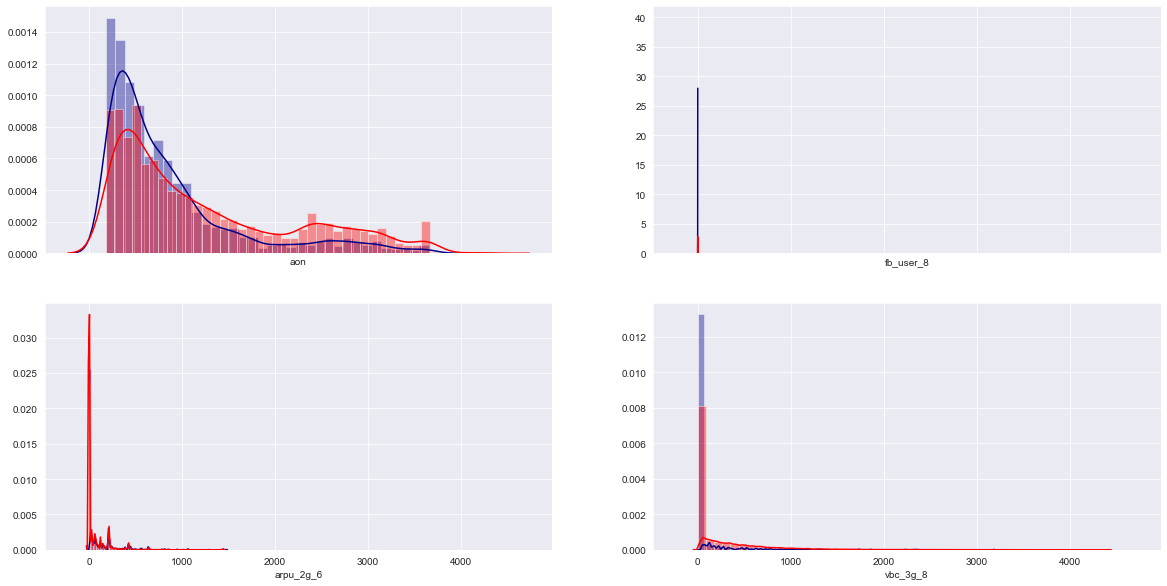

In [367]:
# plot the distribution for important parameters churned and non churned customers and observe
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

sns.distplot( high_value_cust_data_churn["aon"] , color="darkblue", ax=axes[0, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["fb_user_8"] , color="darkblue", ax=axes[0, 1], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["arpu_2g_6"] , color="darkblue", ax=axes[1, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["vbc_3g_8"] , color="darkblue", ax=axes[1, 1], norm_hist=False, kde=True)

sns.distplot( high_value_cust_data_Nochurn["aon"] , color="red", ax=axes[0, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["fb_user_8"] , color="red", ax=axes[0, 1], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["arpu_2g_6"] , color="red", ax=axes[1, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["vbc_3g_8"] , color="red", ax=axes[1, 1], norm_hist=False, kde=True)

- High number of newer customers with the telecom provider seem to be churning more indicating that the quality of service might be an issue. Similar indications are coming from vb_3g_8 data as well.

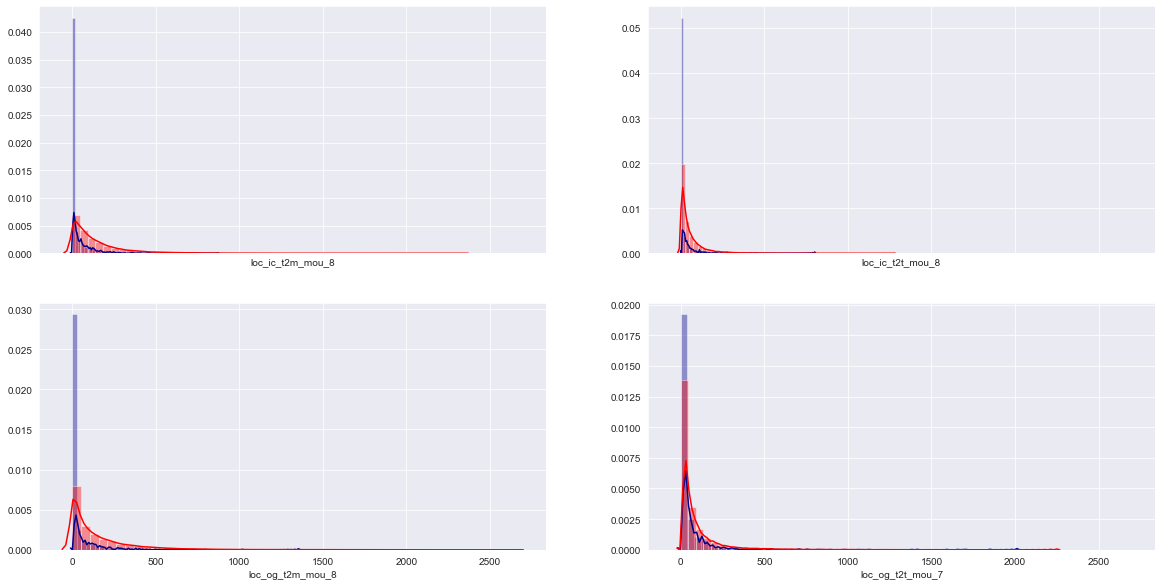

In [365]:
# plot the distribution for local call parameters for both churned and non churned customers and observe
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

sns.distplot( high_value_cust_data_churn["loc_ic_t2m_mou_8"] , color="darkblue", ax=axes[0, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["loc_ic_t2t_mou_8"] , color="darkblue", ax=axes[0, 1], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["loc_og_t2m_mou_8"] , color="darkblue", ax=axes[1, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_churn["loc_og_t2t_mou_7"] , color="darkblue", ax=axes[1, 1], norm_hist=False, kde=True)

sns.distplot( high_value_cust_data_Nochurn["loc_ic_t2m_mou_8"] , color="red", ax=axes[0, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["loc_ic_t2t_mou_8"] , color="red", ax=axes[0, 1], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["loc_og_t2m_mou_8"] , color="red", ax=axes[1, 0], norm_hist=False, kde=True)
sns.distplot( high_value_cust_data_Nochurn["loc_og_t2t_mou_7"] , color="red", ax=axes[1, 1], norm_hist=False, kde=True)

- High number of customers with few calls locally seem to be churning indicating network or call quality issues. 

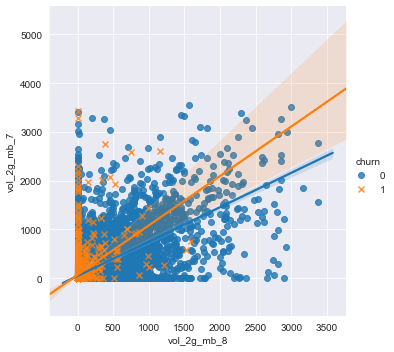

In [332]:
g = sns.lmplot(x="vol_2g_mb_8", y="vol_2g_mb_7", hue="churn", data=high_value_cust_data,
               markers=["o", "x"])

- Both 3G and 2G data customers with low usage are churning indicating that cost of usage for low data usage might be higher.

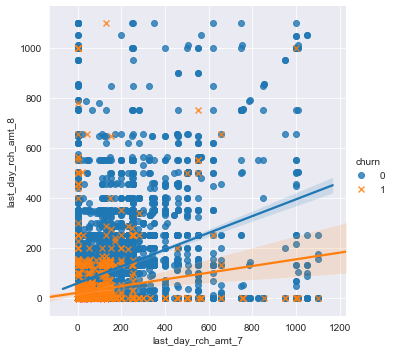

In [336]:
g = sns.lmplot(x="last_day_rch_amt_7", y="last_day_rch_amt_8", hue="churn", data=high_value_cust_data,
               markers=["o", "x"])

- People who are recharging with lower amounts are churning, indicating that they are unhappy. Need to lure them with offers.

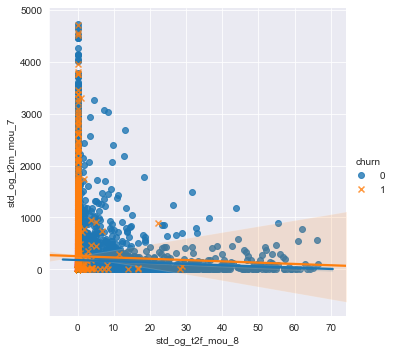

In [337]:
g = sns.lmplot(x="std_og_t2f_mou_8", y="std_og_t2m_mou_7", hue="churn", data=high_value_cust_data,
               markers=["o", "x"])

- Customers who make std mobile to mobile calls are churning more. Possibly the std-call rates for mobile to mobile is higher.

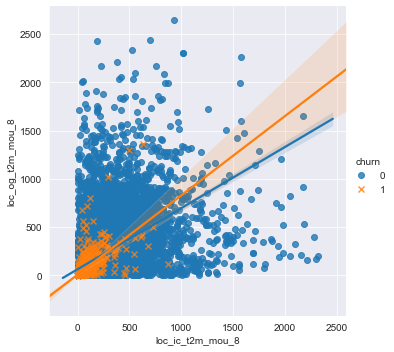

In [366]:
g = sns.lmplot(x="loc_ic_t2m_mou_8", y="loc_og_t2m_mou_8", hue="churn", data=high_value_cust_data,
               markers=["o", "x"])

- Customers who have started to make and recieve very few calls are in churning eventually. Indicates service issues.

### Summary: <br>

#### Best Fit Model:

Logistic Regression model seems to perform best among the three models with Train as well as Test data    
**Train data: Sensitivity/ Recall 84%** |    
**Test data: Sensitivity/ Recall 83%** |    
**ROC Curve 82%**

#### Important Features:

Most important features observed after performing Logistic regression using RFE based feature tuning are, <br>

- 'roam_ic_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_8', 'std_og_t2m_mou_7', 'std_og_t2f_mou_8',
- 'isd_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_7',
- 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'total_ic_mou_6', 'spl_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 
- 'total_rech_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'vol_2g_mb_7', 'vol_2g_mb_8', 'arpu_2g_6', 
- 'monthly_2g_7', 'sachet_2g_6', 'sachet_3g_7', 'fb_user_8', 'aon', 'vbc_3g_8', 'total_data_rech_amt_8'


#### Recommendations:

**Customers who are churning seem to be having following issues:**
 - Possible call quality issues as customers are churning who seem to have spent little time with the telecom provider.
 - Customers who are making std out going calls from mobilt to mobile are churning more indicating that the call charges might be higher for std.
 - Data pack charges might need to be revisited to understand the churn behaviour with low data usage customers. Possibly the data slab rate is higher at lower usages.
 - Telecom provider should call in customers with low outging or incoming local calls to understand their satisfaction quotient. 
     - Might need to offer special discounts or package options or improve network quality based on the feedback provided.